###  importing relevant libraries

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
import sklearn
import time
import os
warnings.filterwarnings("ignore")

In [2]:
renamer={}

### Discovering Labels

In [15]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    #df["Label"]=df["Label"].replace(renamer)
    #print(df["Label"].unique())
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [4]:
def folder(f_name): #this function creates a folder.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("Tthe folder could not be created!")

In [5]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

In [6]:
altime=0
#def most_frequent(List): 
#    return max(set(List), key = List.count) 


 
def most_frequent(List):
    occurence_count = Counter(List)
    occurence_count={k: v for k, v in sorted(occurence_count.items(), key=lambda item: item[1],reverse=True)}
    big=list(occurence_count.values())
    big=big.count(big[0])
    return list(occurence_count.keys())[np.random.randint(big)]


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second

## Calculation of evaluations

In [7]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ml):
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,i,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time,altime]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return line,class_based_results

In [28]:
def ML(loop1,loop2,output_csv1,cols,step,mixed,dname):

    
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        output_csv=output_csv1.replace("ML",ii)
        repetition=100
        lines=[["Dataset","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T","Al-Time"]]
        for i in tqdm(range(repetition)):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            df=df.fillna(0) 
            df["Label"]=df["Label"].replace(renamer)
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            df=df.fillna(0) 
            df["Label"]=df["Label"].replace(renamer)
            df = shuffle(df, random_state=42)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes




            results_y=[]
            cv+=1
            results_y.append(y_test)


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            #print(clf.get_params())
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
                
                
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/(repetition)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
  
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","CB.csv"))
        if True:
            cm=cm//repetition
            graph_name=output_csv+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            cm.to_csv(graph_name.replace(".pdf",".csv"))
            plt.show()
            #print(cm)
            #print("\n\n\n")             


            #plt.clf()

            
            
            
            
            



# Machine learning applications 

In [9]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
'Label']


In [10]:
ml_list={"DT" :DecisionTreeClassifier(criterion='entropy', max_depth=19,
                       max_features=4,min_samples_split= 2)}

# IoTDevID

# Individual

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [37:23<00:00, 22.44s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_1          0     1  DT    0.989    0.901   0.935  0.901  0.91   0.988      0    1.008     0.48           0
 1  t_1          1     2  DT    0.989    0.9     0.935  0.9    0.91   0.988      0    1.376     0.543          0
 2  t_1          2     3  DT    0.988    0.901   0.91   0.901  0.894  0.987      0    0.996     0.588          0
 3  t_1          3     4  DT    0.989    0.901   0.935  0.901  0.91   0.988      0    1.014     0.539          0
 4  t_1          4     5  DT    0.988    0.9     0.91   0.9    0.894  0.987      0    1.37      0.531          0
 5  t_1          5     6  DT    0.989    0.901   0.934  0.901  0.91   0.988      0    1.079     0.502          0
 6  t_1          6     7  DT    0.989    0.9     0.935  0.9    0.91   0.988      0    1.112     

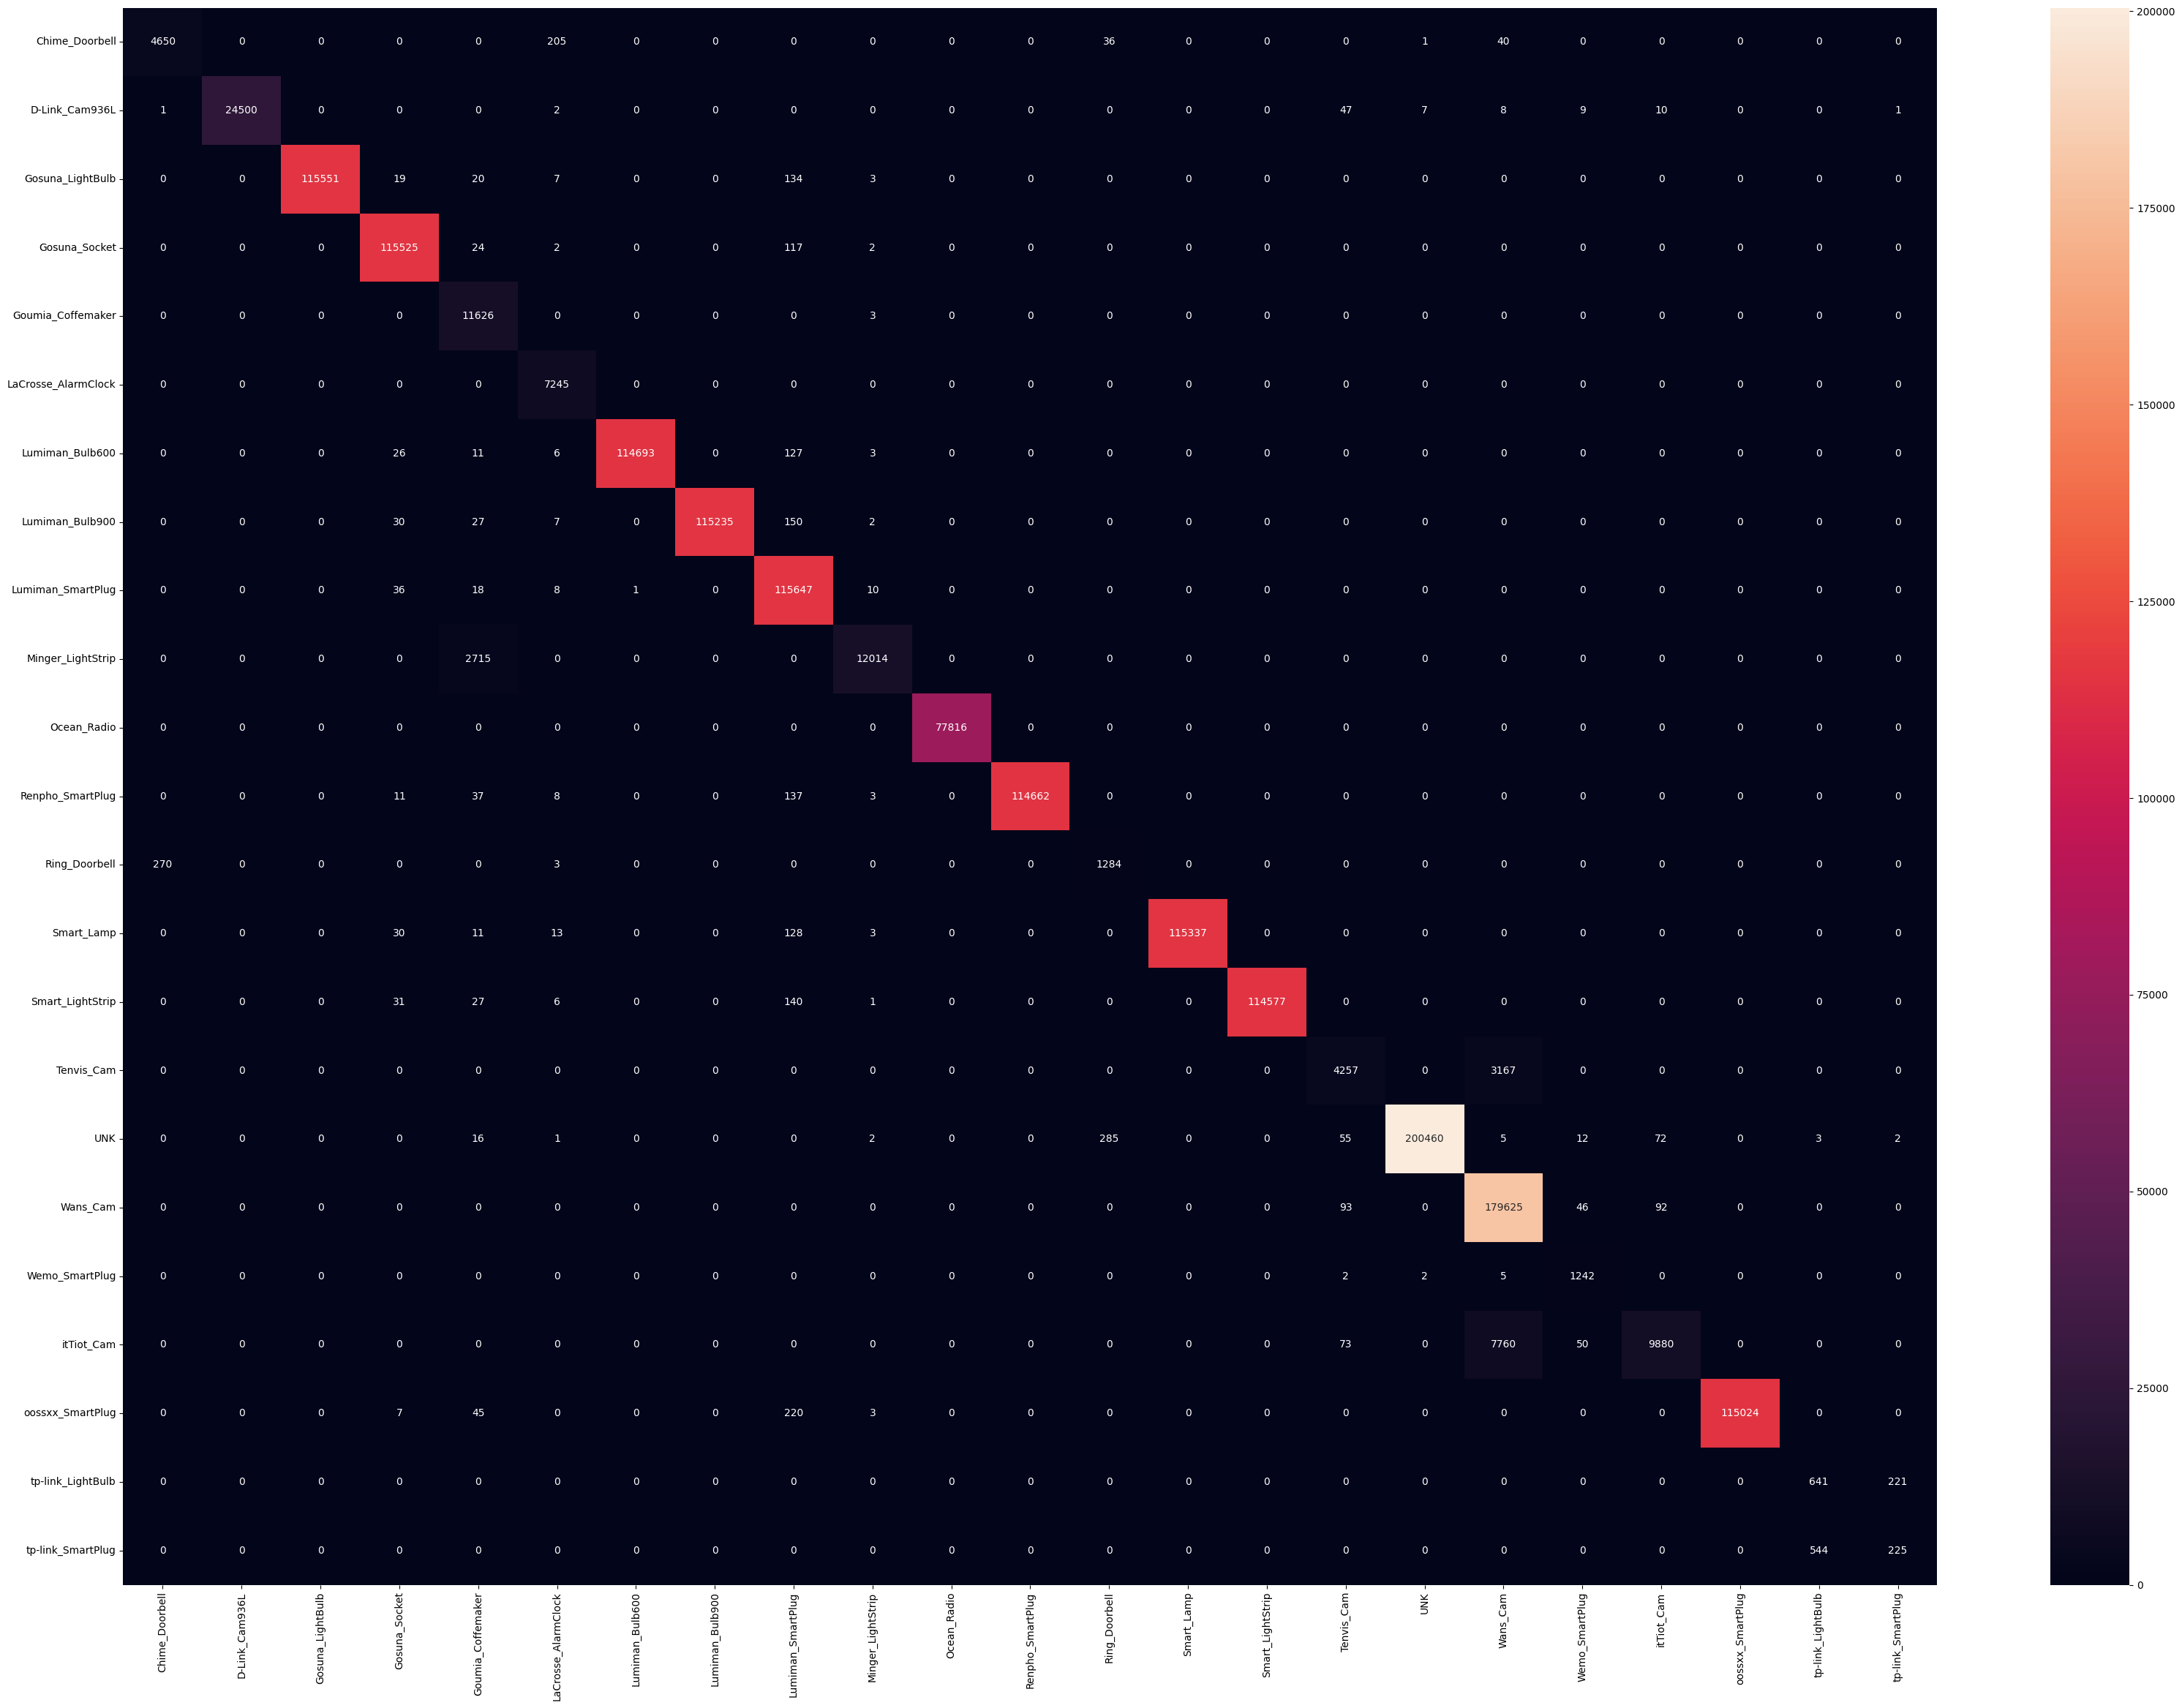

In [11]:
say=0
dataset="./results/1/"
folder(dataset)

dataset="./results/1/"
say+=1
train="Train.csv"
test="Test.csv"
mixed=False
step=1
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{step}.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 

# Aggregated

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:22:44<00:00, 49.64s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_13         0     1  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    0.93      0.48      26.952
 1  t_13         1     2  DT    0.994    0.93    0.967  0.93   0.93   0.994      0    1.148     0.488     27.918
 2  t_13         2     3  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    1.132     0.504     24.981
 3  t_13         3     4  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    1.069     0.472     26.971
 4  t_13         4     5  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    0.934     0.488     26.432
 5  t_13         5     6  DT    0.994    0.931   0.961  0.931  0.932  0.994      0    1.18      0.504     27.757
 6  t_13         6     7  DT    0.994    0.93    0.967  0.93   0.93   0.994      0    1.067     

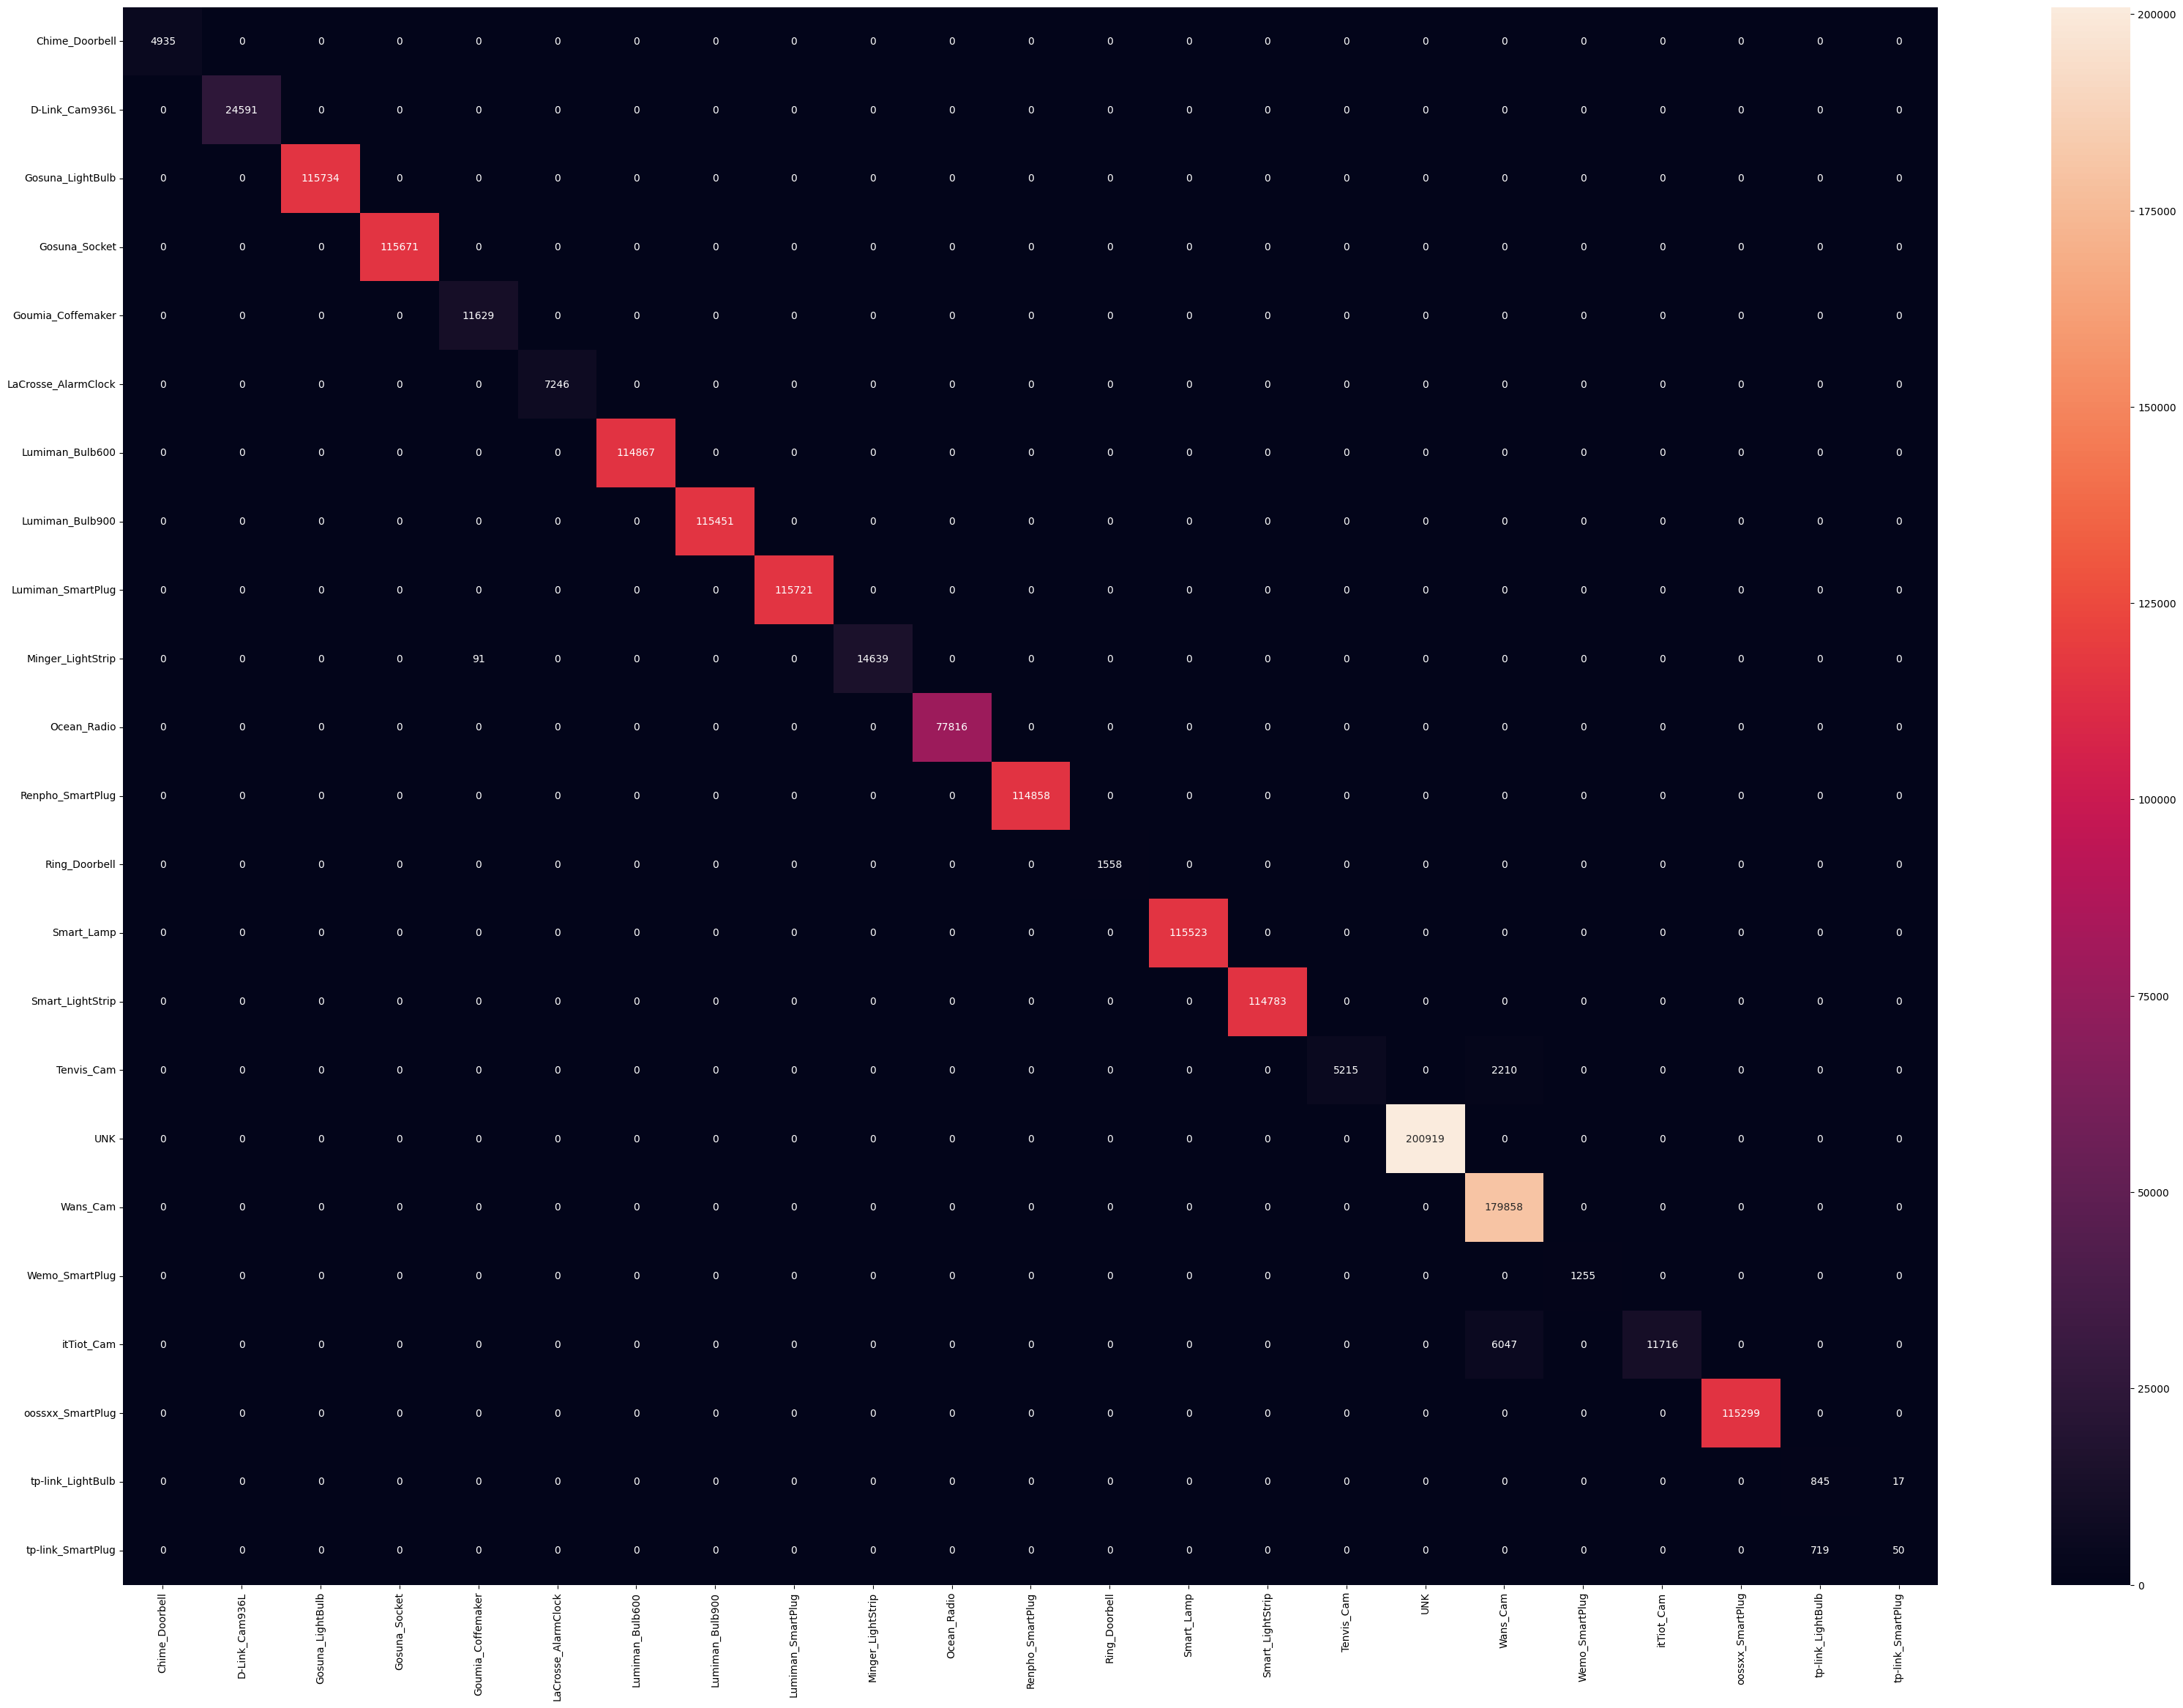

In [12]:
say=0
dataset="./results/13/"
folder(dataset)

dataset="./results/13/"
say+=1
train="Train.csv"
test="Test.csv"
mixed=False
step=13
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{step}-{mixed}.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 

# Mixed

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:23:31<00:00, 50.11s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_13         0     1  DT    0.994    0.93    0.969  0.93   0.931  0.994      0    0.921     0.455     30.951
 1  t_13         1     2  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    1.023     0.484     27.937
 2  t_13         2     3  DT    0.994    0.93    0.961  0.93   0.932  0.994      0    0.997     0.487     26.747
 3  t_13         3     4  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    0.93      0.449     26.065
 4  t_13         4     5  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    1.03      0.488     27.248
 5  t_13         5     6  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    0.954     0.478     28.585
 6  t_13         6     7  DT    0.994    0.931   0.969  0.931  0.931  0.994      0    1.036     

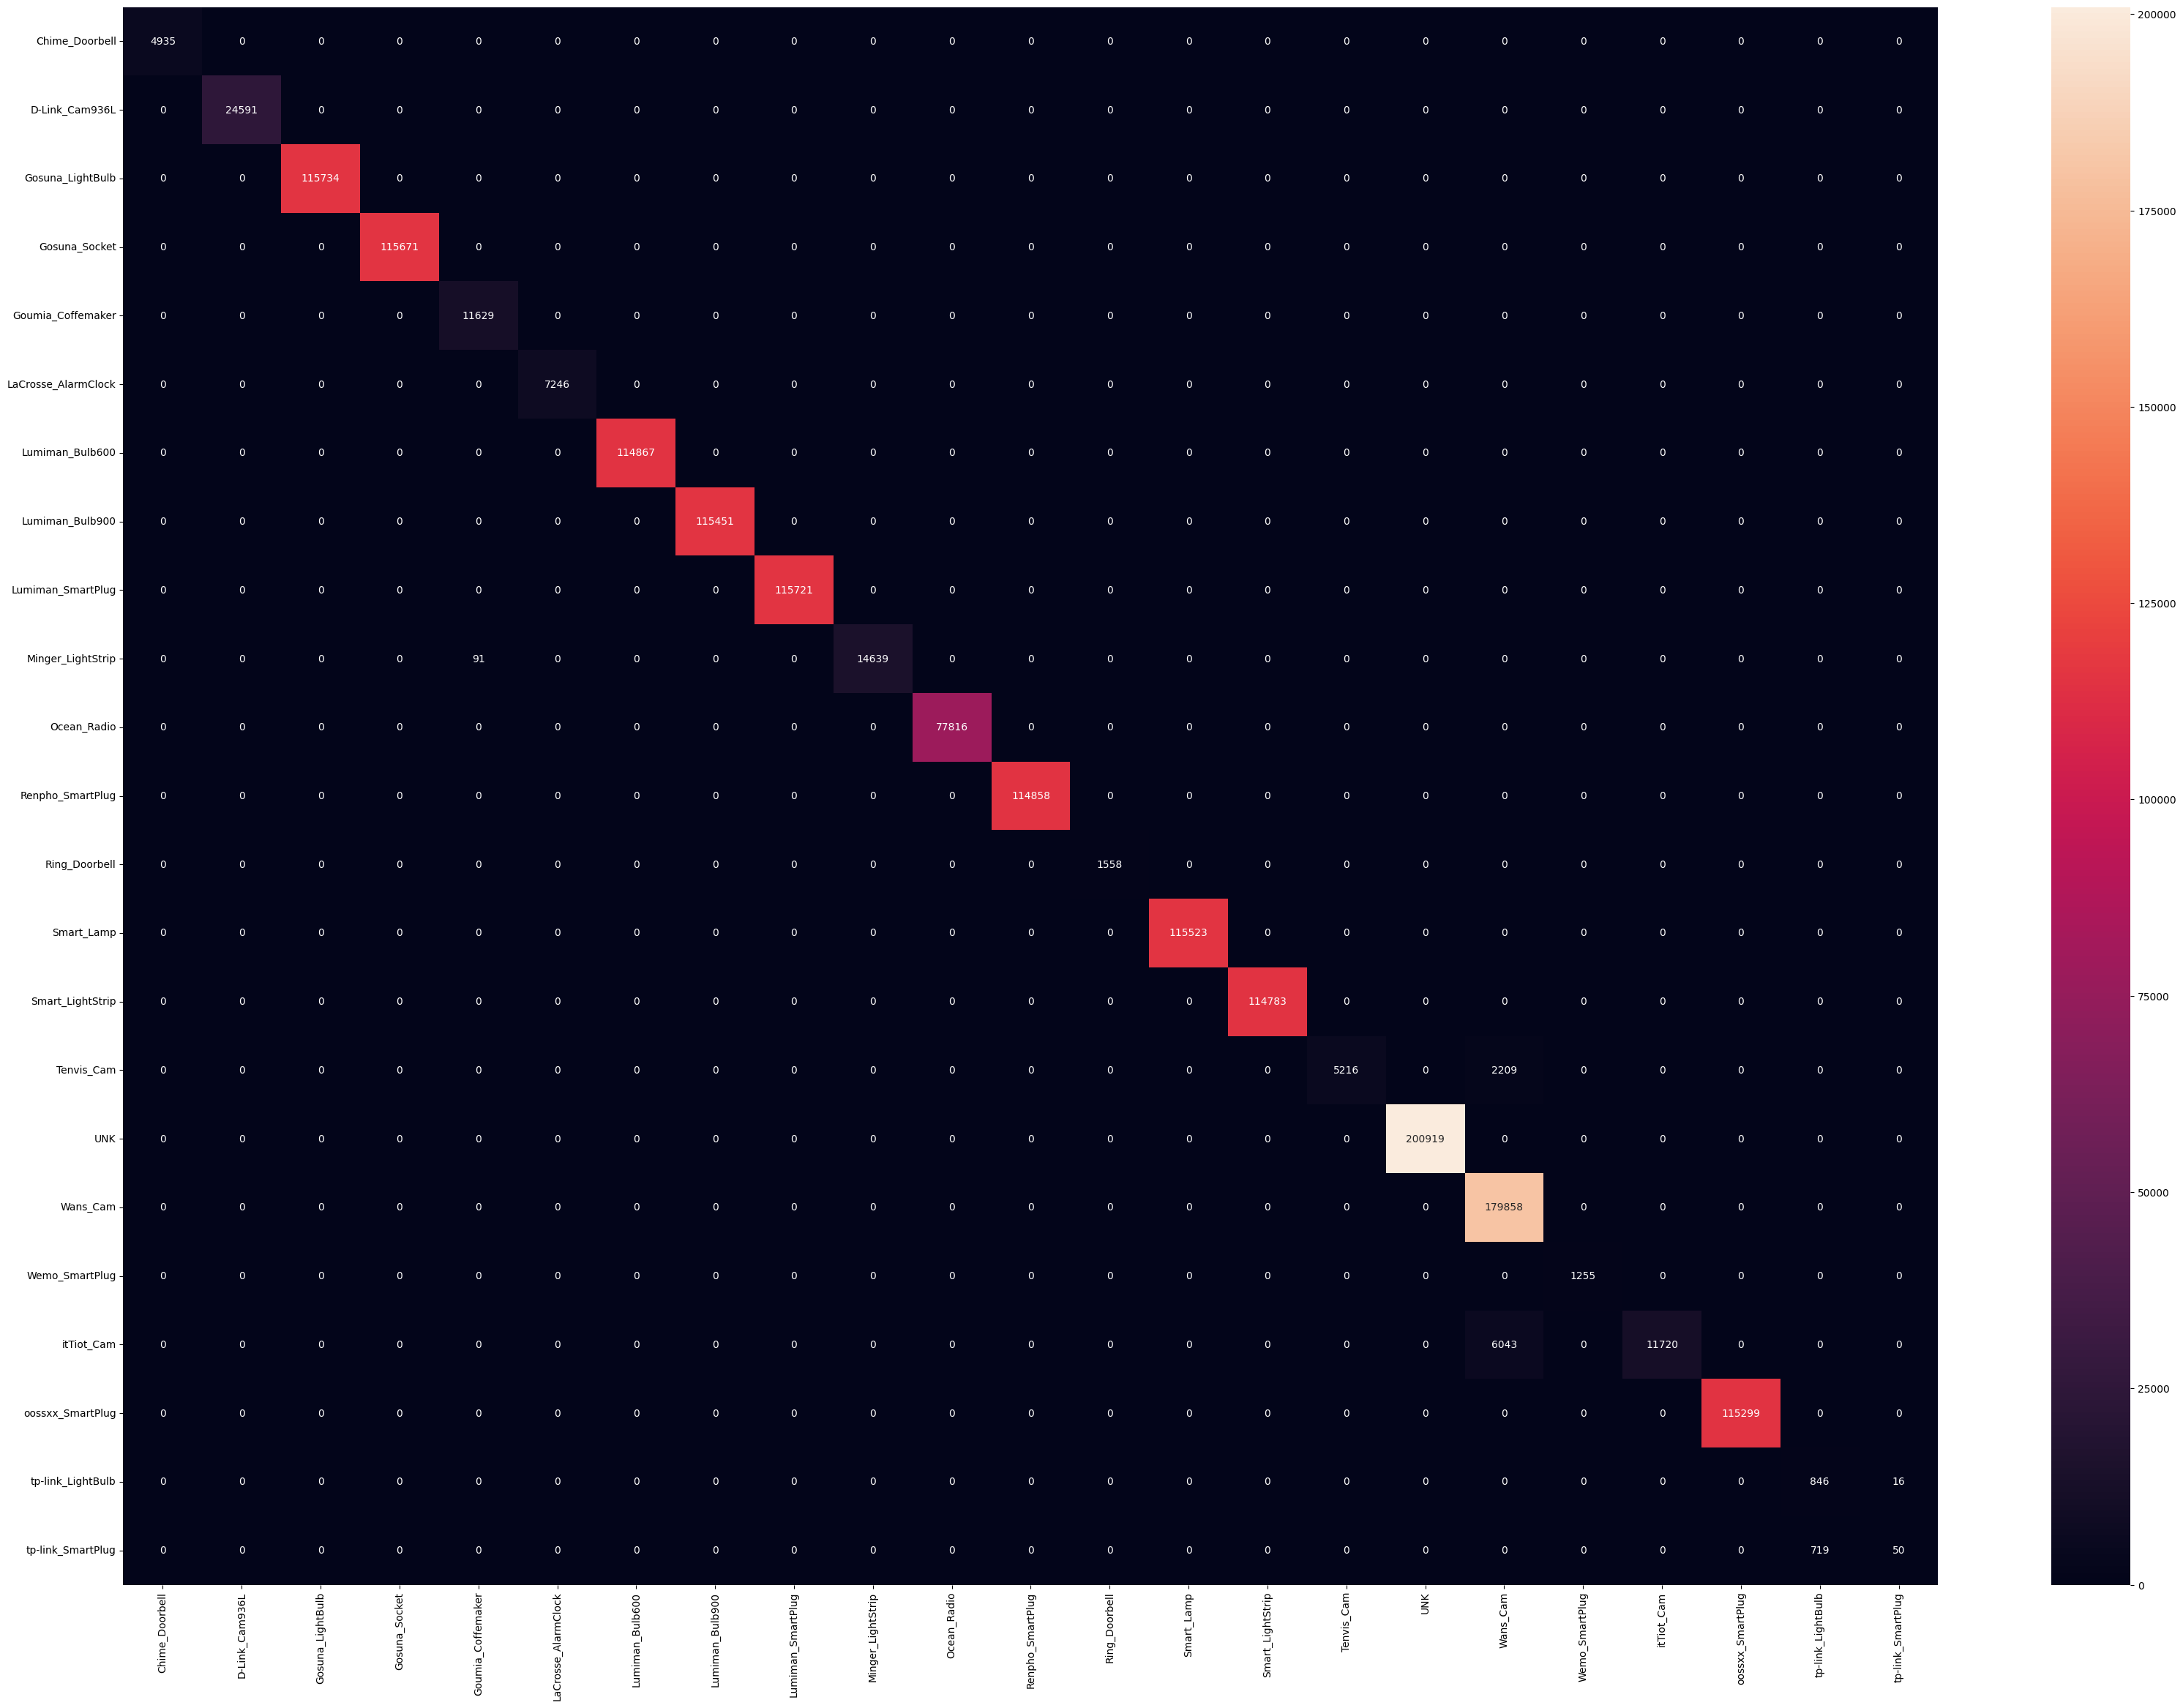

In [13]:
say=0
dataset="./results/13/"
folder(dataset)

dataset="./results/13/"
say+=1
train="Train.csv"
test="Test.csv"
mixed=True
step=13
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{mixed}.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 

# IoTSense

In [29]:
feature=['ARP', 'EAPOL', 'IP', 'ICMP', 'ICMP6', 'TCP', 'UDP', 'TCP_w_size',
       'HTTP', 'HTTPS', 'DHCP', 'BOOTP', 'SSDP', 'DNS', 'MDNS', 'NTP',
       'IP_padding', 'IP_ralert', 'payload_l', 'Entropy',"MAC",
       'Label']

In [30]:
ml_list={"DT" :DecisionTreeClassifier(criterion='gini', max_depth=23,
                       max_features=16,min_samples_split= 2)}

# 0  gini                  23              16                    2  0.904342  1.11022e-16    5.18     2

# Individual

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [33:45<00:00, 20.25s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_1          0     1  DT    0.986    0.884   0.912  0.884  0.888  0.985      0    1.772     0.445          0
 1  t_1          1     2  DT    0.986    0.884   0.895  0.884  0.878  0.985      0    1.939     0.441          0
 2  t_1          2     3  DT    0.986    0.883   0.896  0.883  0.878  0.985      0    2.043     0.429          0
 3  t_1          3     4  DT    0.986    0.884   0.896  0.884  0.878  0.985      0    2.105     0.409          0
 4  t_1          4     5  DT    0.986    0.883   0.911  0.883  0.887  0.985      0    1.807     0.413          0
 5  t_1          5     6  DT    0.986    0.881   0.91   0.881  0.886  0.985      0    1.815     0.453          0
 6  t_1          6     7  DT    0.986    0.883   0.894  0.883  0.877  0.985      0    1.917     

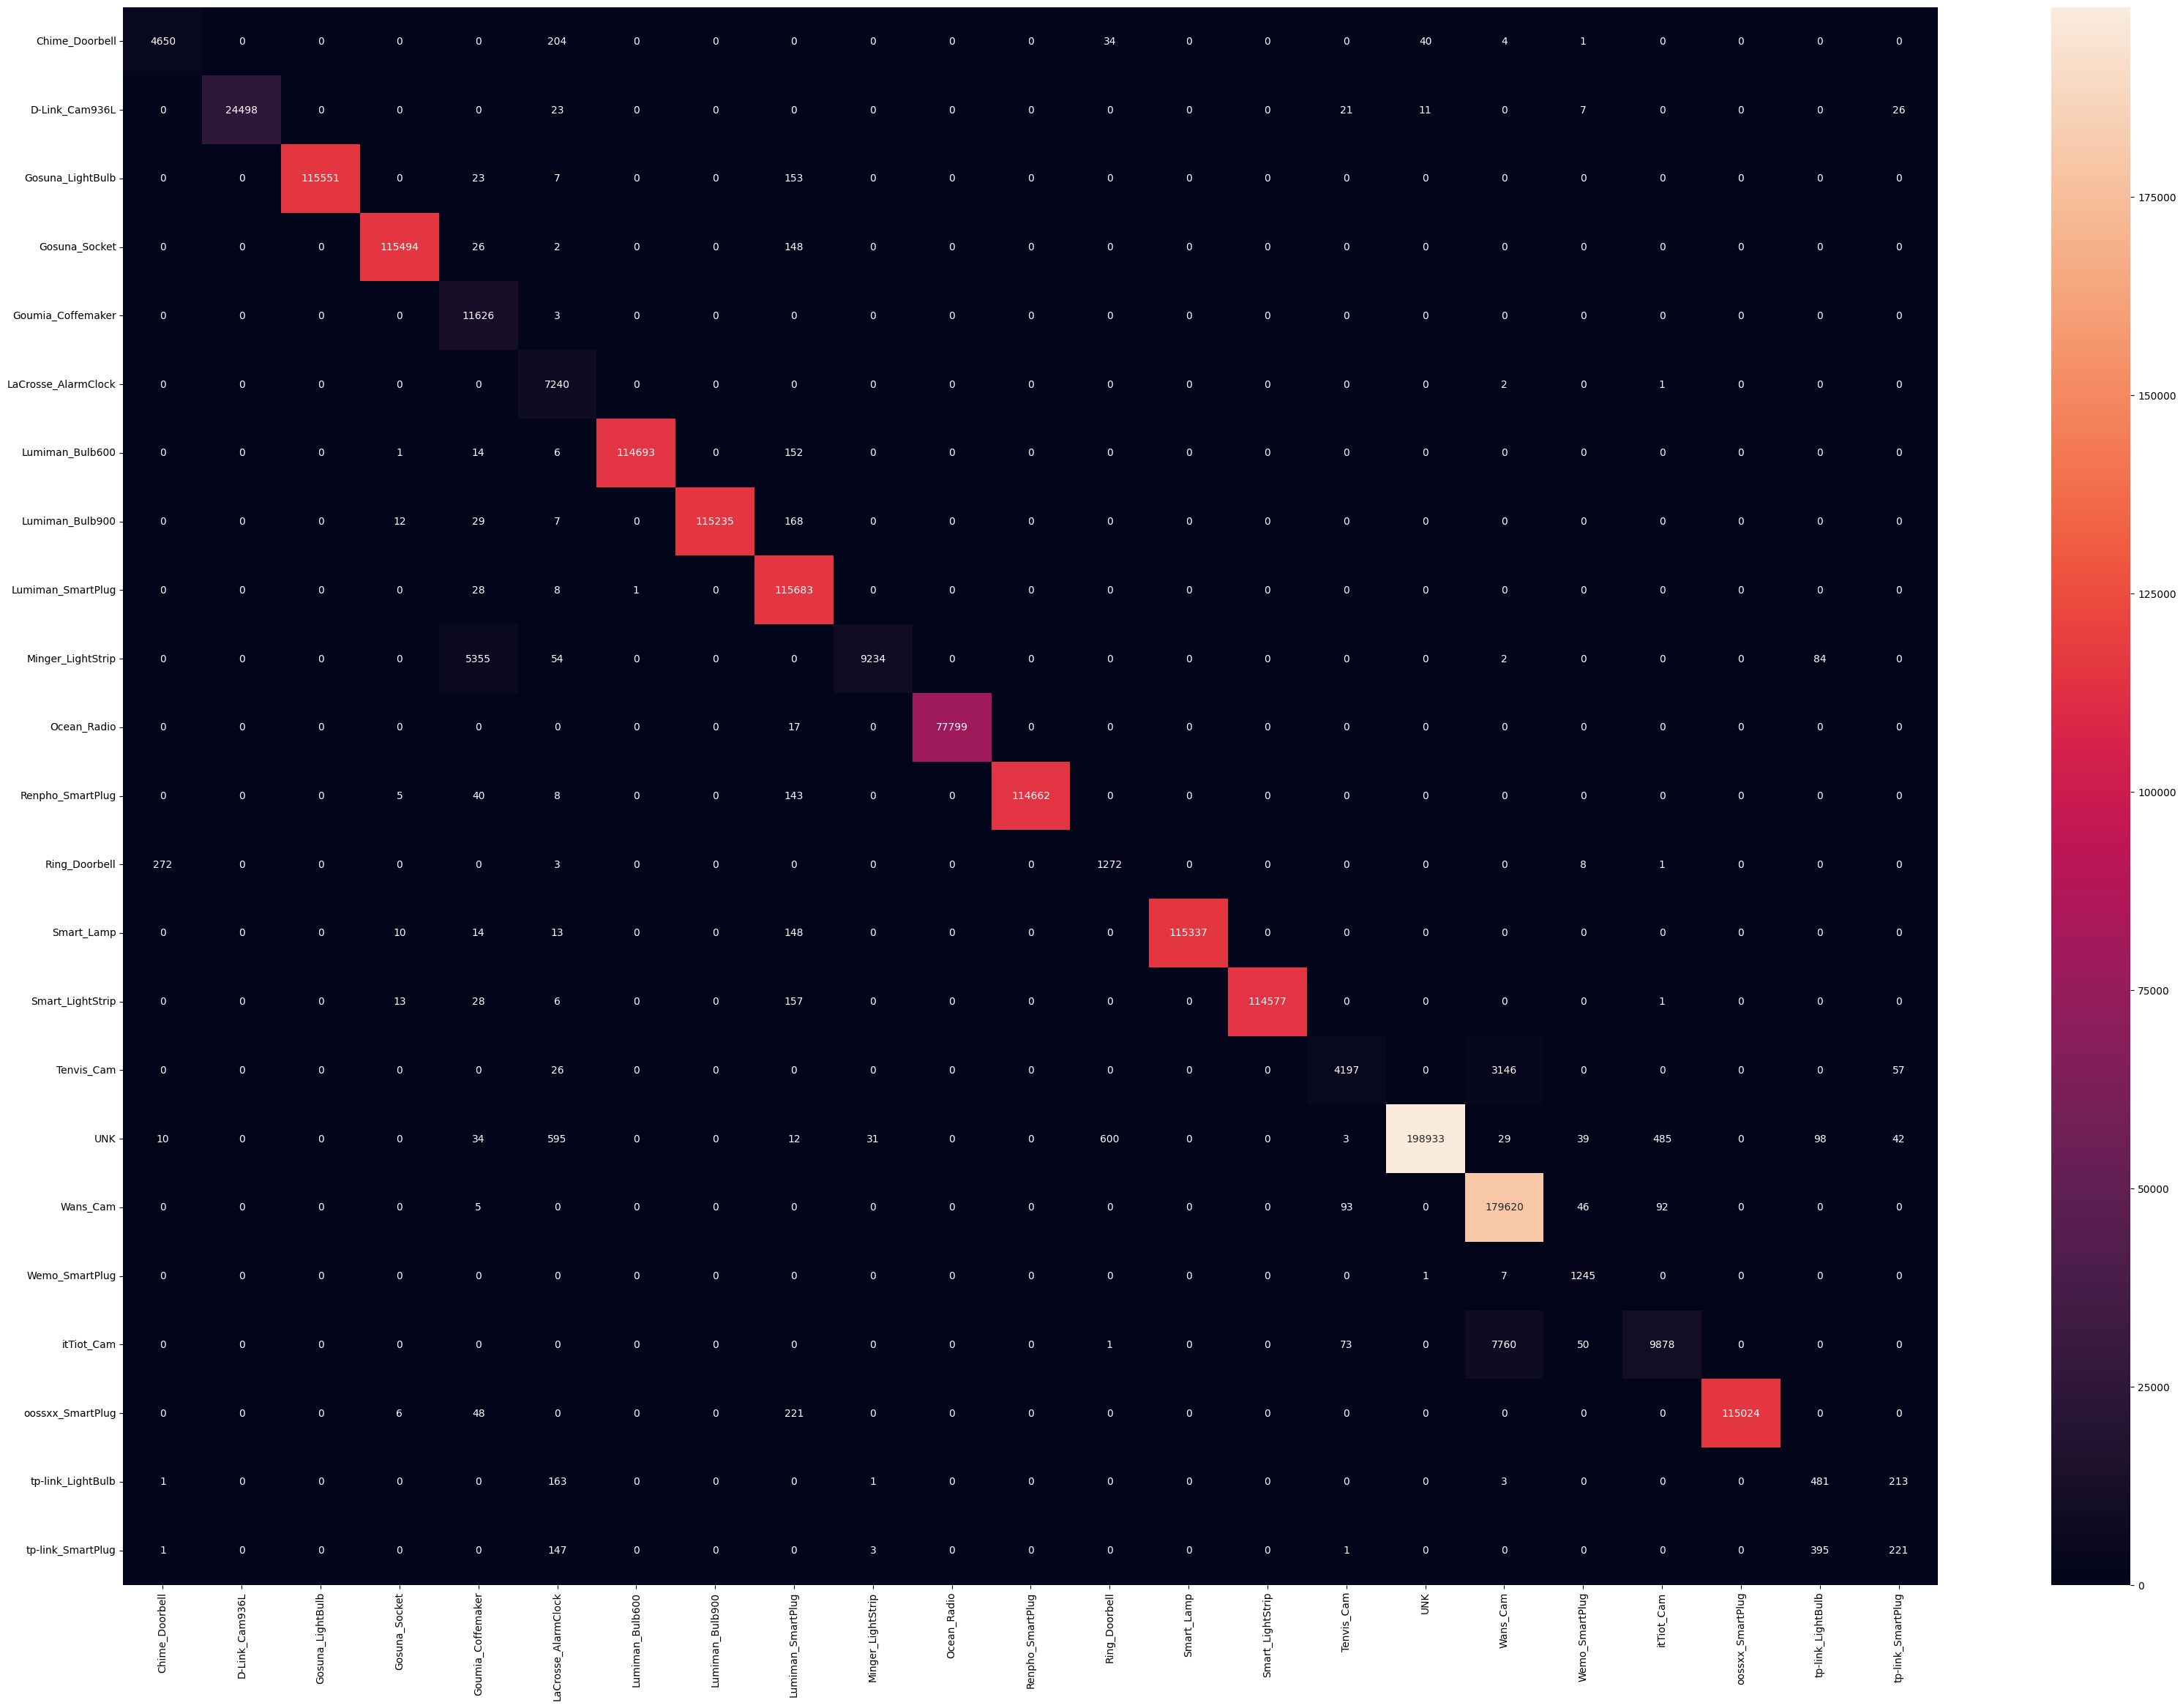

In [31]:
say=0
dataset="./results/1/"
folder(dataset)
dataset="./results/1/"
say+=1
train= 'Train.csv'
test='Test.csv'
mixed=False
step=1
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{step}_IoTSense.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 

# Aggregated

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:18:20<00:00, 47.00s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_13         0     1  DT    0.993    0.926   0.959  0.926  0.932  0.992      0    1.634     0.416     26.996
 1  t_13         1     2  DT    0.993    0.924   0.954  0.924  0.928  0.992      0    2.206     0.43      27.136
 2  t_13         2     3  DT    0.993    0.925   0.957  0.925  0.931  0.992      0    1.618     0.434     26.847
 3  t_13         3     4  DT    0.993    0.927   0.958  0.927  0.932  0.992      0    1.99      0.451     26.471
 4  t_13         4     5  DT    0.993    0.923   0.953  0.923  0.928  0.992      0    2.201     0.439     26.134
 5  t_13         5     6  DT    0.993    0.925   0.955  0.925  0.93   0.992      0    2.215     0.433     27.355
 6  t_13         6     7  DT    0.993    0.926   0.958  0.926  0.931  0.992      0    2.116     

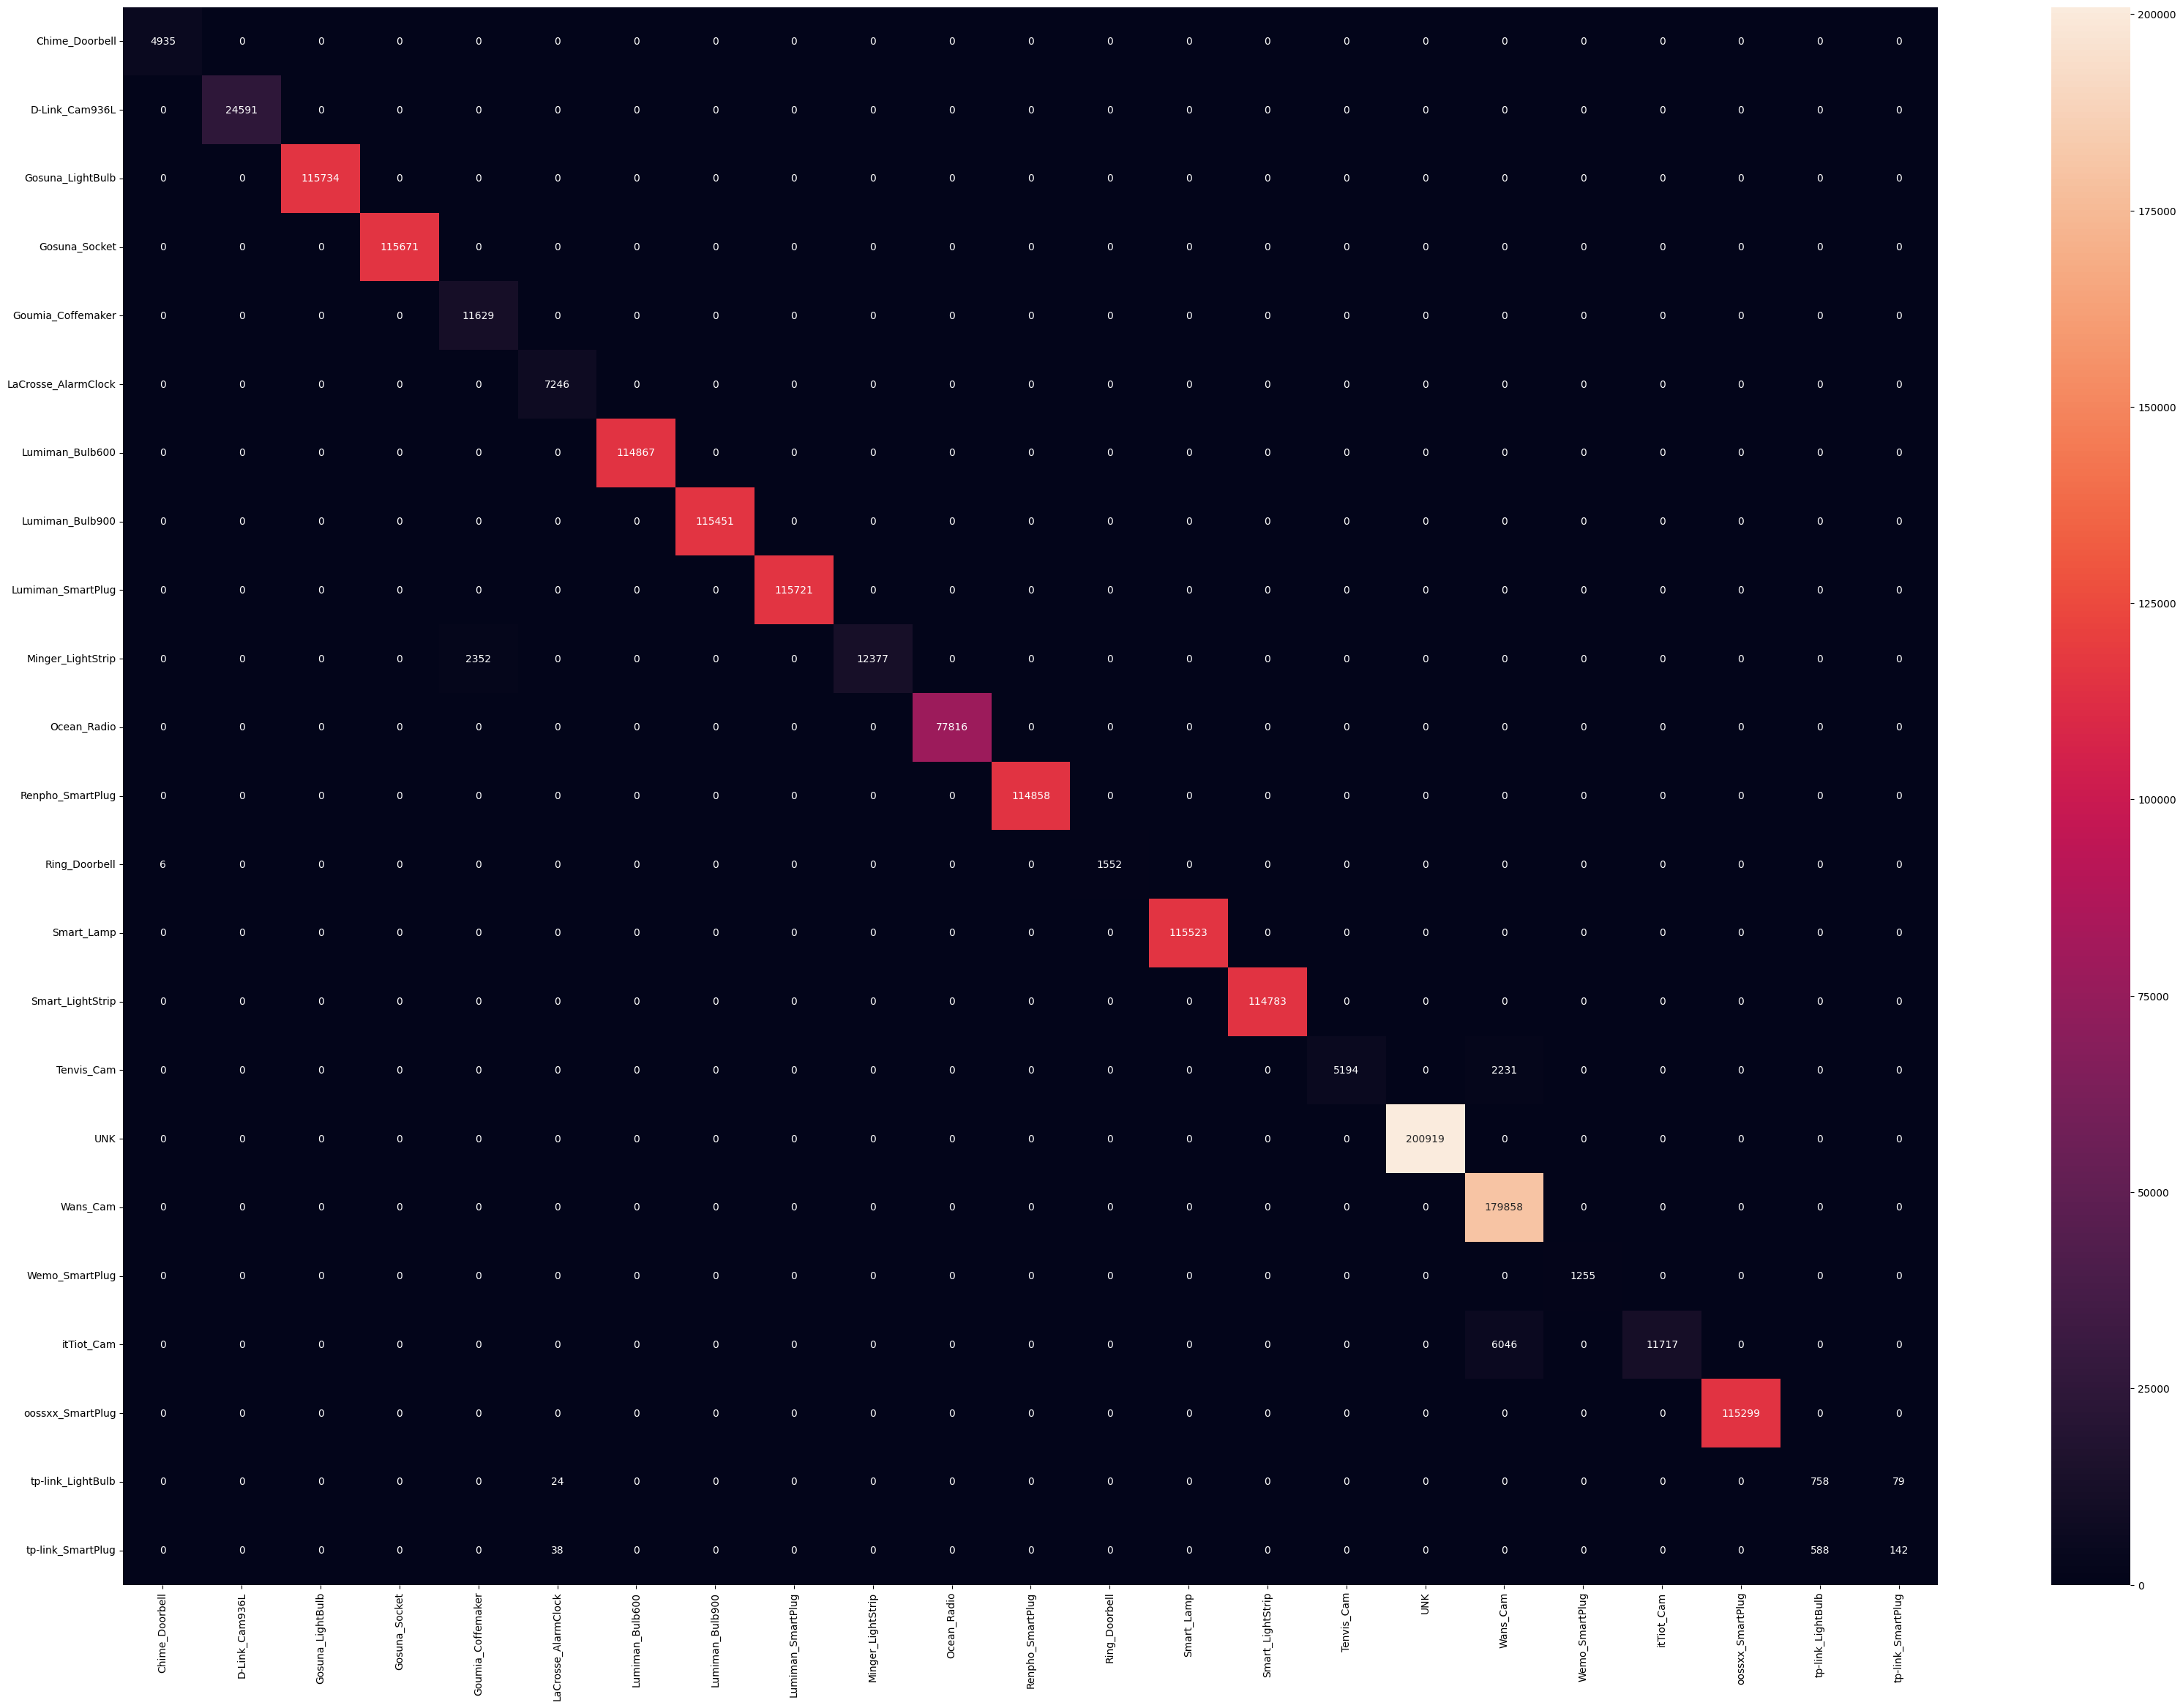

In [32]:
say=0
dataset="./results/13/"
folder(dataset)

dataset="./results/13/"
say+=1
train= 'Train.csv'
test='Test.csv'
mixed=False
step=13
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{step}-{mixed}_IoTSense.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 

# Mixed

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:19:07<00:00, 47.48s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_13         0     1  DT    0.993    0.924   0.956  0.924  0.93   0.992      0    2.075     0.424     27.744
 1  t_13         1     2  DT    0.993    0.925   0.955  0.925  0.93   0.992      0    2.007     0.436     27.171
 2  t_13         2     3  DT    0.993    0.925   0.956  0.925  0.93   0.992      0    1.652     0.408     27.792
 3  t_13         3     4  DT    0.993    0.924   0.955  0.924  0.929  0.992      0    1.986     0.453     27.484
 4  t_13         4     5  DT    0.993    0.924   0.955  0.924  0.929  0.992      0    1.929     0.444     27.233
 5  t_13         5     6  DT    0.993    0.921   0.954  0.921  0.928  0.992      0    2.115     0.445     27.288
 6  t_13         6     7  DT    0.993    0.925   0.956  0.925  0.931  0.992      0    2.011     

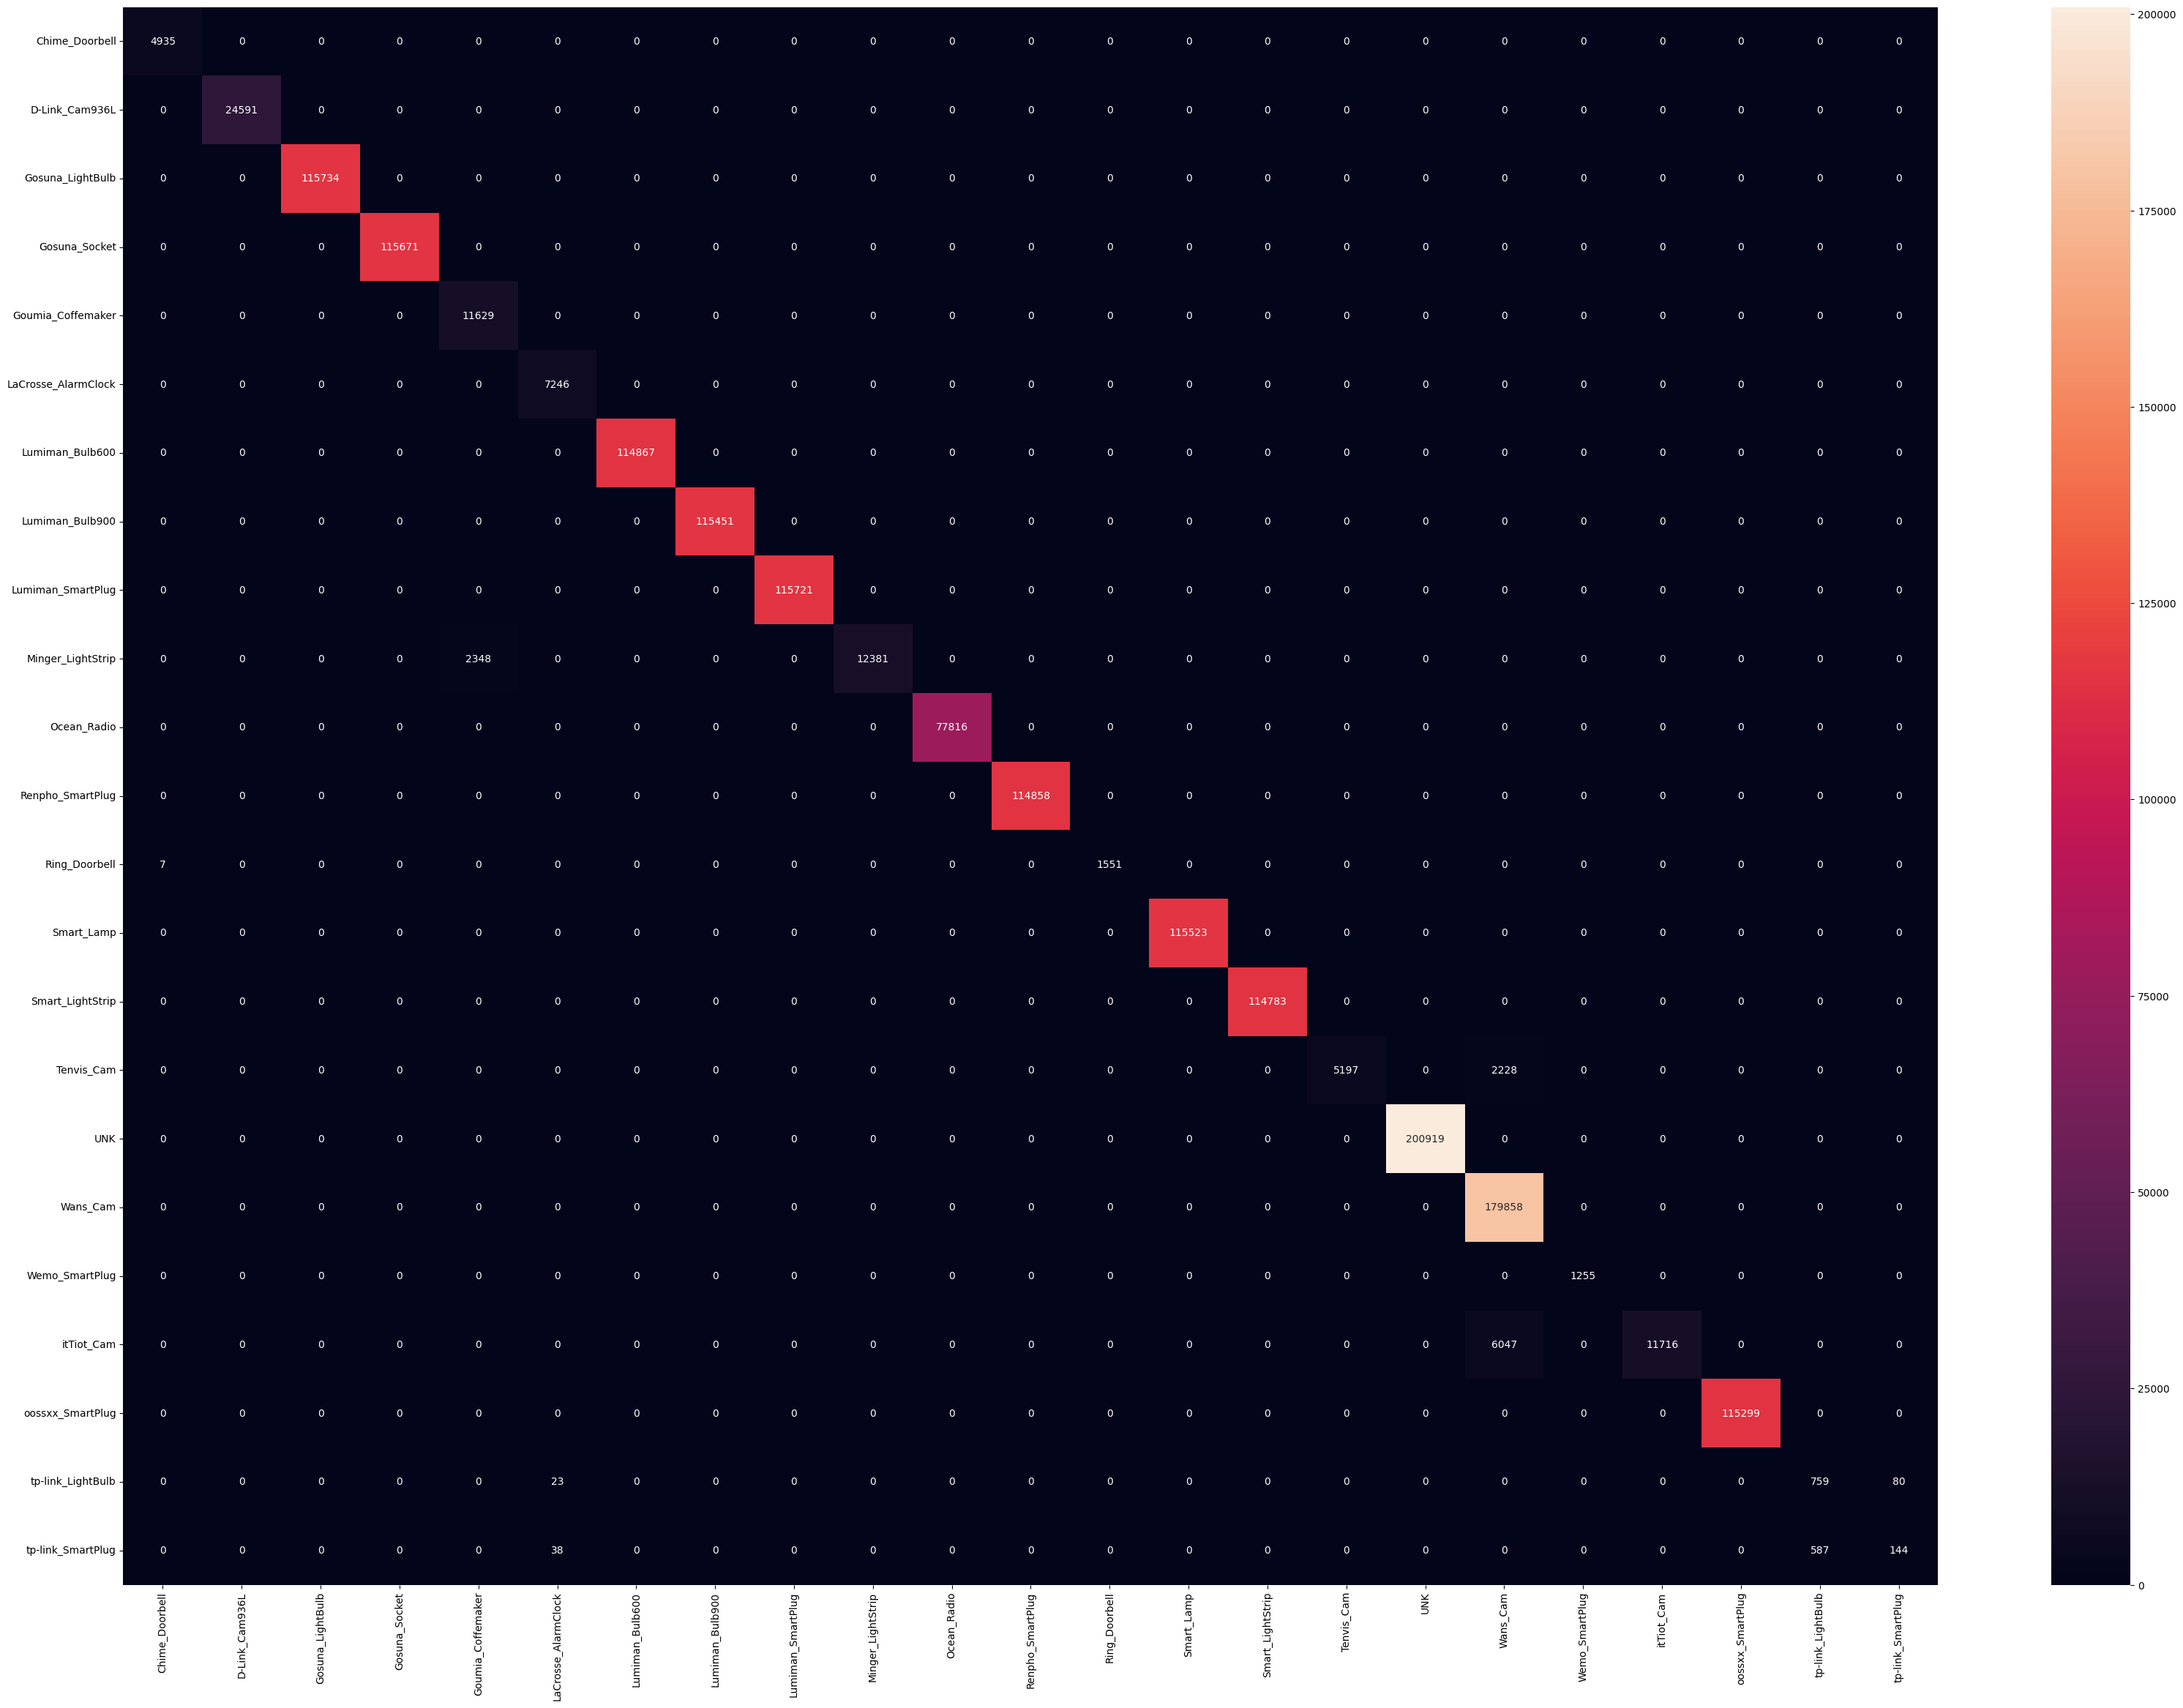

In [33]:
say=0
dataset="./results/13/"
folder(dataset)

dataset="./results/13/"
say+=1
train= 'Train.csv'
test='Test.csv'
mixed=True
step=13
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{mixed}_IoTSense.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 

# IoTSentinel

In [34]:
feature= features=['ARP', 'LLC', 'EAPOL', 'IP', 'ICMP', 'ICMP6', 'TCP', 'UDP', 'HTTP',
       'HTTPS', 'DHCP', 'BOOTP', 'SSDP', 'DNS', 'MDNS', 'NTP', 'IP_padding',
       'IP_add_count', 'IP_ralert', 'Portcl_src', 'Portcl_dst', 'Pck_size',
       'Pck_rawdata', "MAC",'Label']

In [35]:
ml_list={"DT" :DecisionTreeClassifier(criterion='entropy', max_depth=31,
                       max_features=22,min_samples_split= 4)}

In [36]:
  #  criterion      max_depth    max_features    min_samples_split        F1    Std    Time    No
#--  -----------  -----------  --------------  -------------------  --------  -----  ------  ----
# 0  entropy               31              22                    4  0.431388      0   4.383     6

# Individual

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [30:19<00:00, 18.20s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_1          0     1  DT    0.395    0.448   0.454  0.448  0.417  0.343      0    1.109     0.336          0
 1  t_1          1     2  DT    0.395    0.448   0.475  0.448  0.417  0.343      0    1.082     0.364          0
 2  t_1          2     3  DT    0.395    0.448   0.475  0.448  0.417  0.343      0    1.135     0.359          0
 3  t_1          3     4  DT    0.395    0.448   0.475  0.448  0.417  0.343      0    1.073     0.341          0
 4  t_1          4     5  DT    0.395    0.448   0.475  0.448  0.417  0.343      0    0.996     0.356          0
 5  t_1          5     6  DT    0.395    0.448   0.453  0.448  0.417  0.343      0    1.126     0.346          0
 6  t_1          6     7  DT    0.395    0.448   0.476  0.448  0.417  0.343      0    1.111     

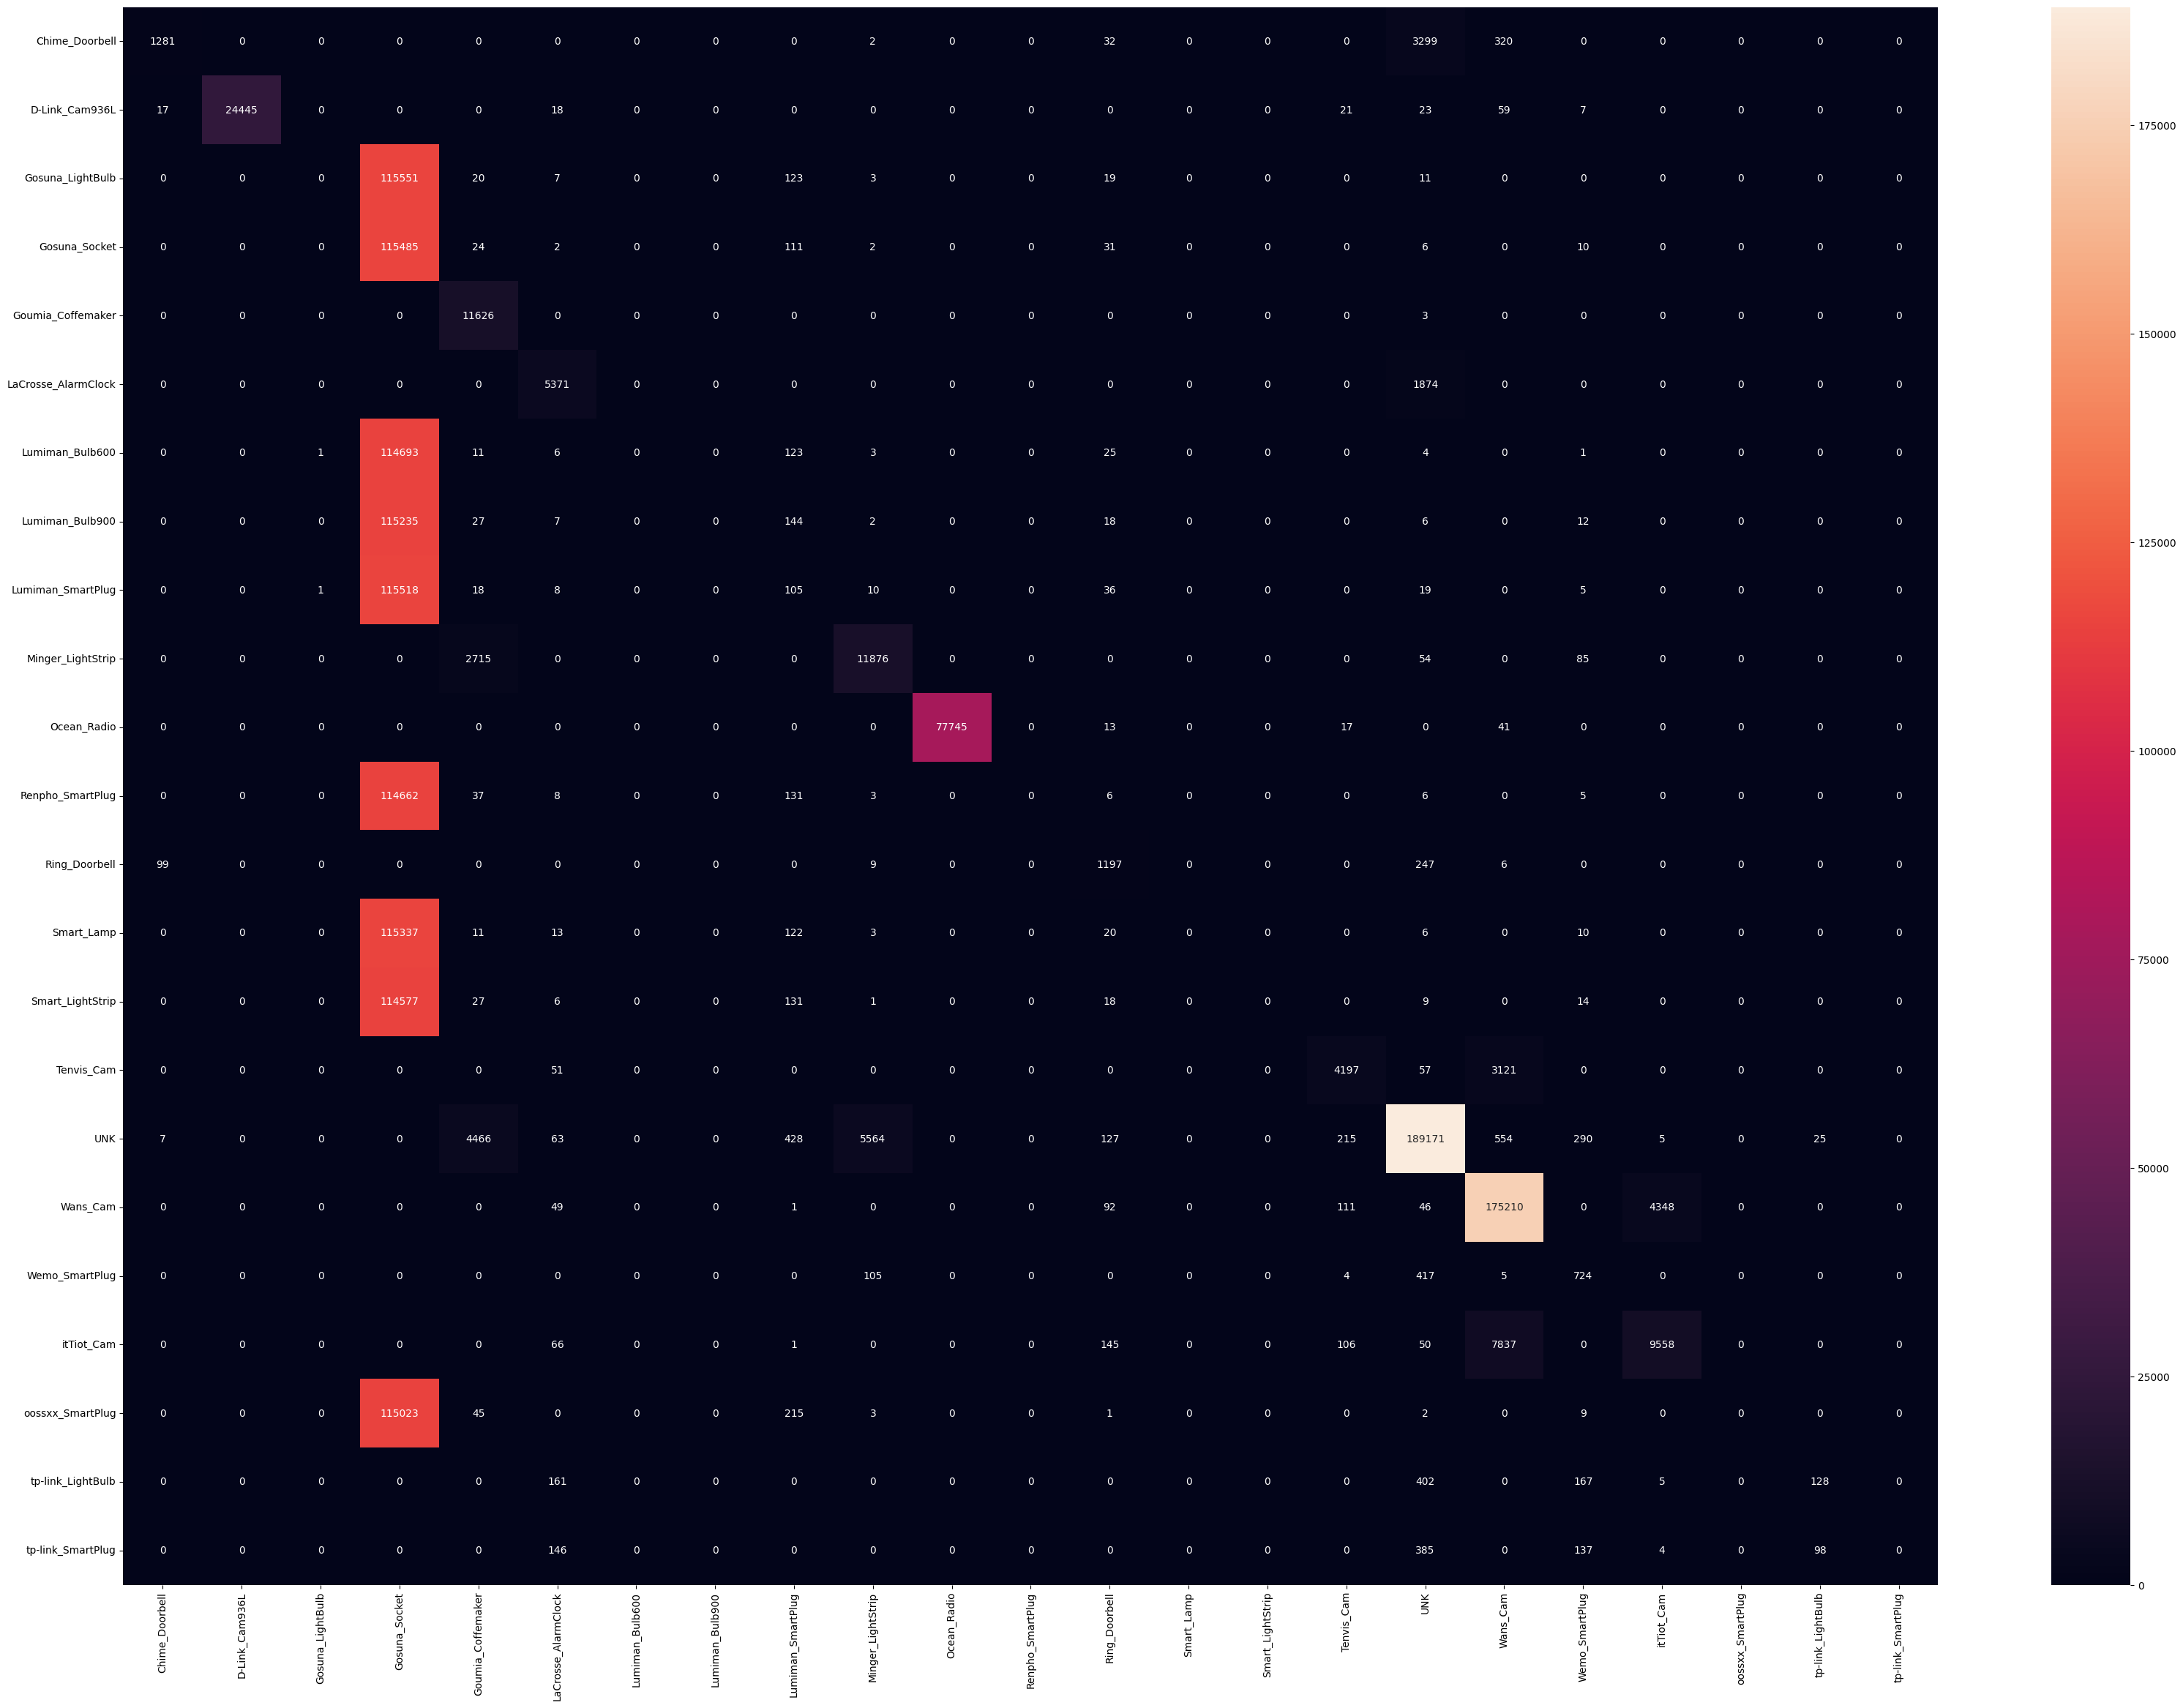

In [37]:
say=0
dataset="./results/1/"
folder(dataset)

dataset="./results/1/"
say+=1
train= 'Train.csv'
test='Test.csv'
mixed=False
step=1
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{step}_IoTSentinel.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 

# Aggregated

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:15:22<00:00, 45.22s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_13         0     1  DT     0.41    0.489   0.548  0.489  0.47   0.359      0    1.154     0.362     27.273
 1  t_13         1     2  DT     0.41    0.488   0.547  0.488  0.469  0.359      0    1.165     0.358     27.219
 2  t_13         2     3  DT     0.41    0.489   0.548  0.489  0.469  0.359      0    1.105     0.373     26.857
 3  t_13         3     4  DT     0.41    0.488   0.547  0.488  0.469  0.359      0    1.145     0.359     26.834
 4  t_13         4     5  DT     0.41    0.488   0.547  0.488  0.468  0.358      0    1.117     0.361     27.276
 5  t_13         5     6  DT     0.41    0.489   0.547  0.489  0.468  0.359      0    1.113     0.345     26.643
 6  t_13         6     7  DT     0.41    0.489   0.548  0.489  0.469  0.358      0    1.189     

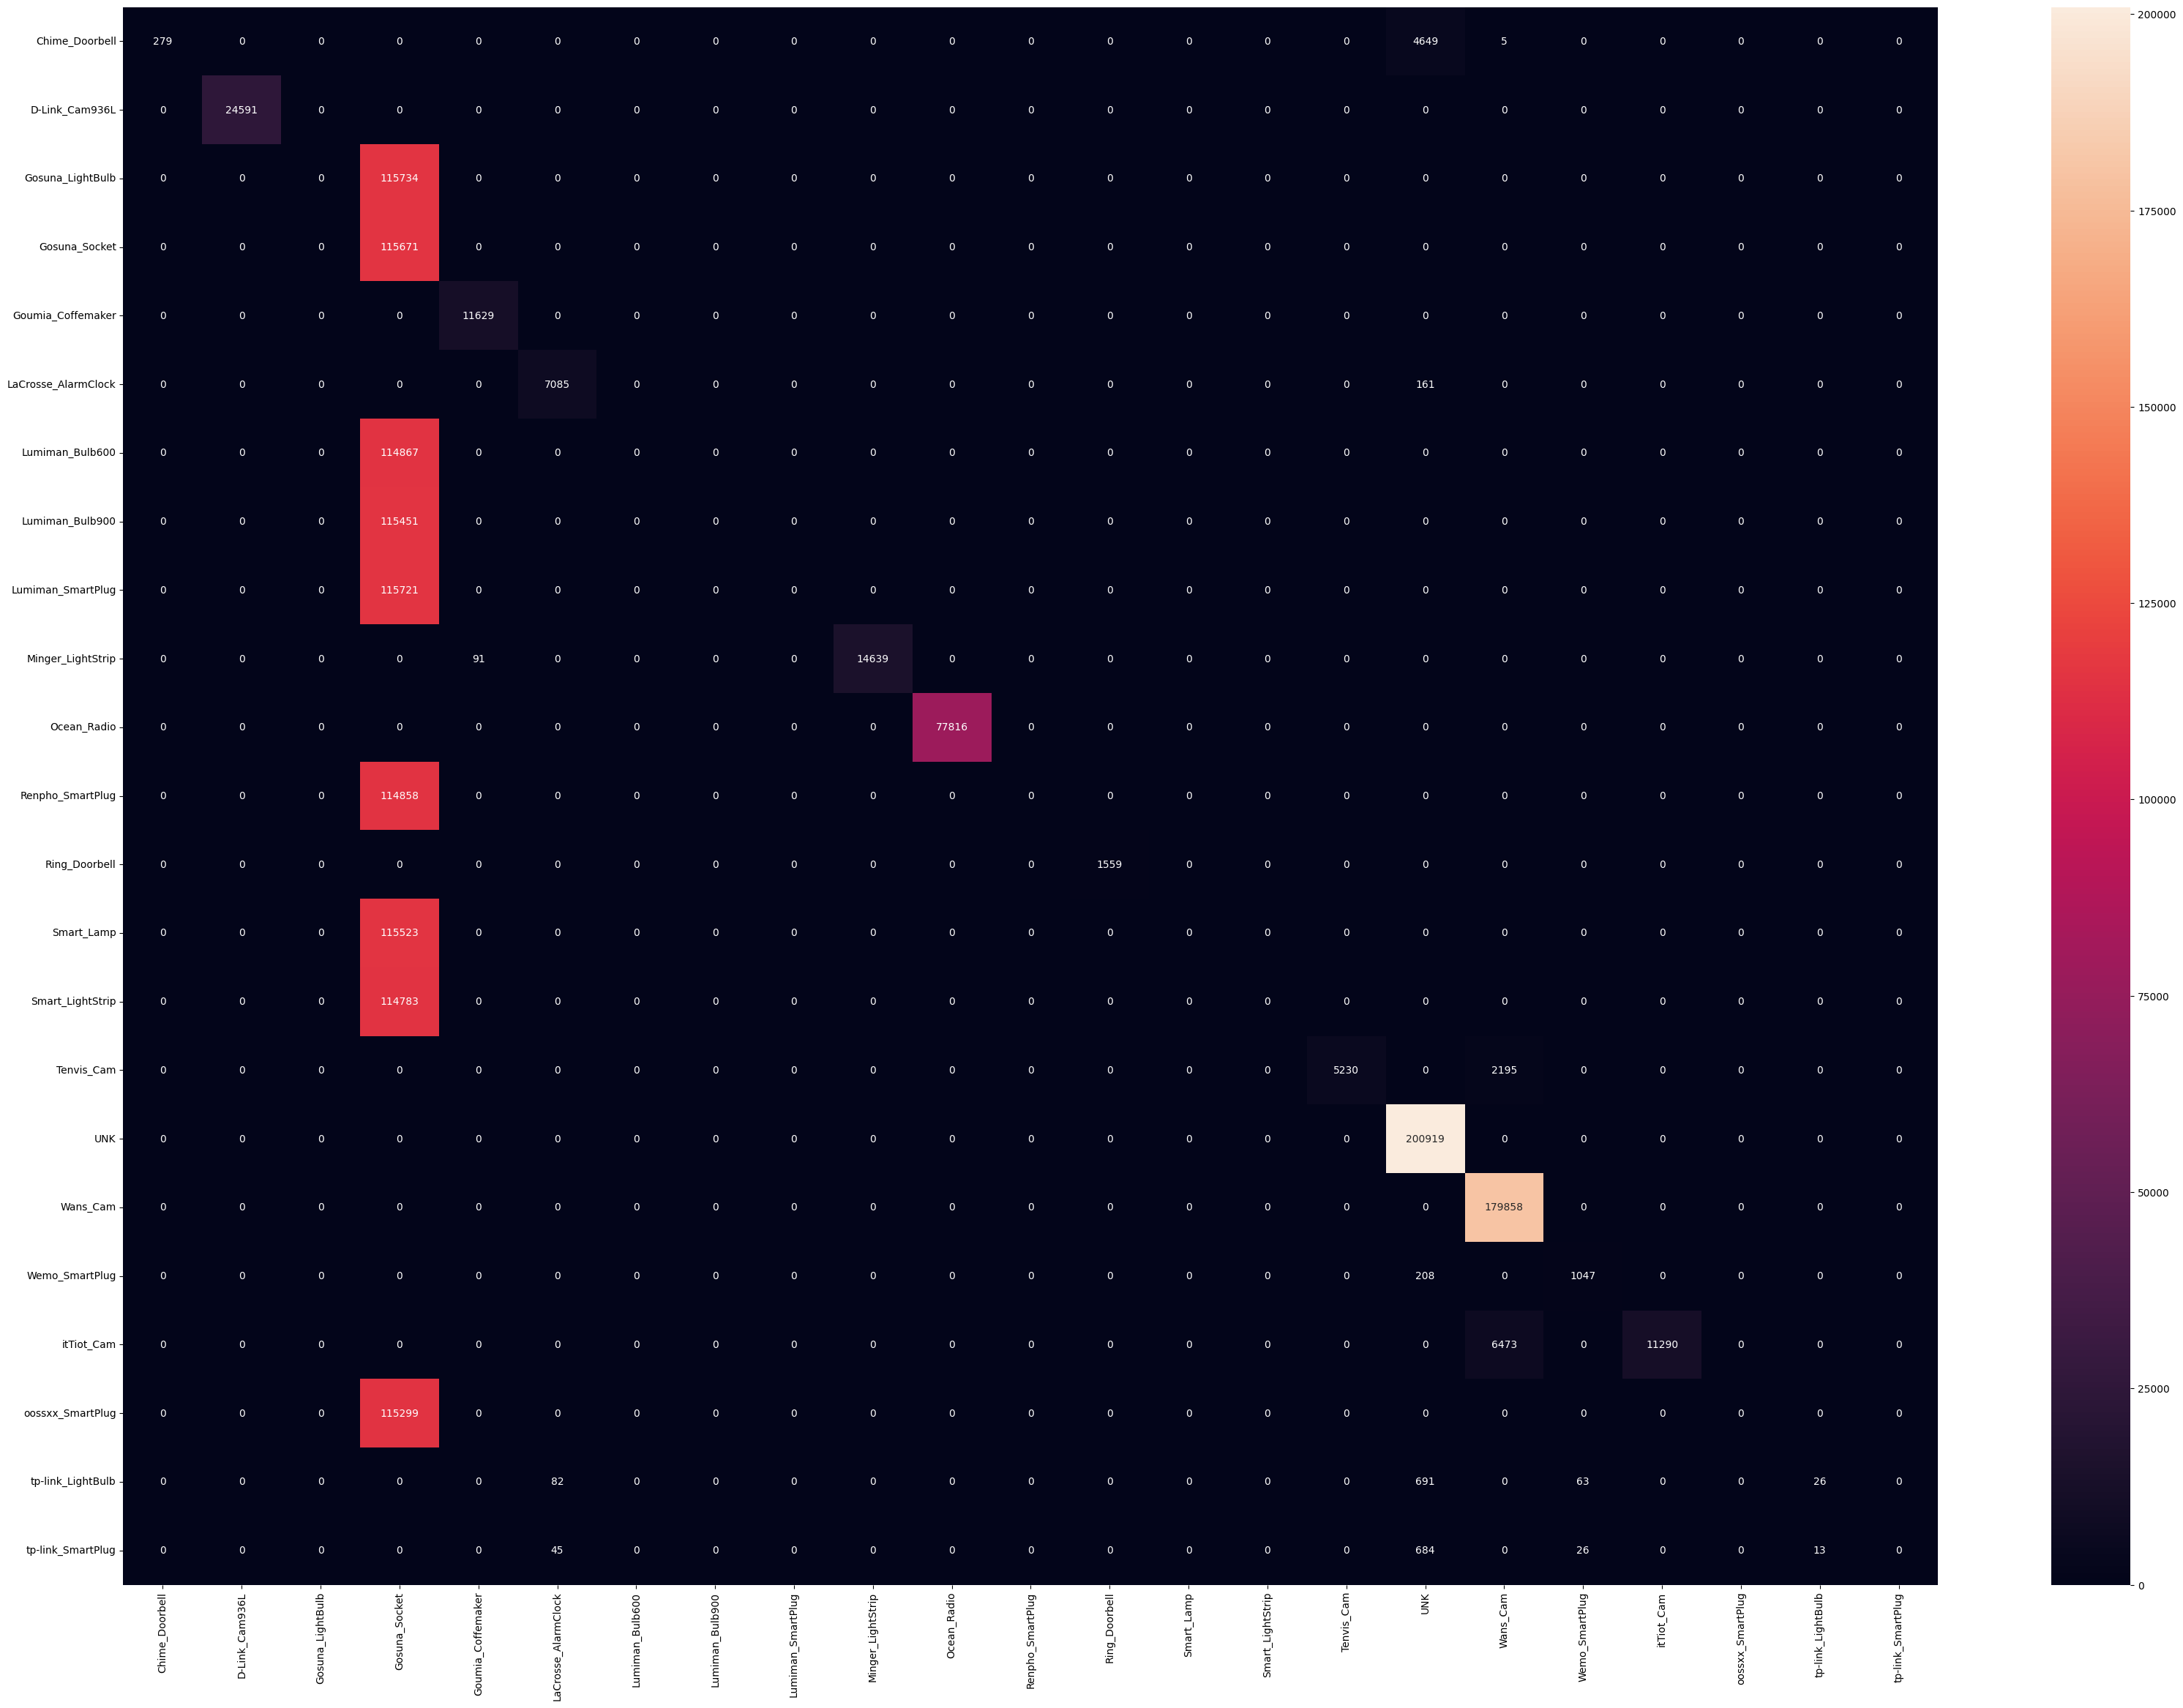

In [38]:
say=0
dataset="./results/13/"
folder(dataset)

dataset="./results/13/"
say+=1
train= 'Train.csv'
test='Test.csv'
mixed=False
step=13
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{step}-{mixed}_IoTSentinel.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 

# Mixed

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:12:52<00:00, 43.73s/it]


    Dataset      T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  ---------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  t_13         0     1  DT     0.41    0.489   0.548  0.489  0.469  0.359      0    1.096     0.371     27.305
 1  t_13         1     2  DT     0.41    0.488   0.548  0.488  0.469  0.358      0    1.106     0.372     27.971
 2  t_13         2     3  DT     0.41    0.489   0.548  0.489  0.47   0.359      0    1.156     0.381     27.407
 3  t_13         3     4  DT     0.41    0.488   0.548  0.488  0.469  0.358      0    1.044     0.361     28.822
 4  t_13         4     5  DT     0.41    0.489   0.548  0.489  0.469  0.359      0    1.103     0.386     27.083
 5  t_13         5     6  DT     0.41    0.488   0.547  0.488  0.468  0.358      0    1.132     0.352     27.297
 6  t_13         6     7  DT     0.41    0.489   0.547  0.489  0.469  0.359      0    0.969     

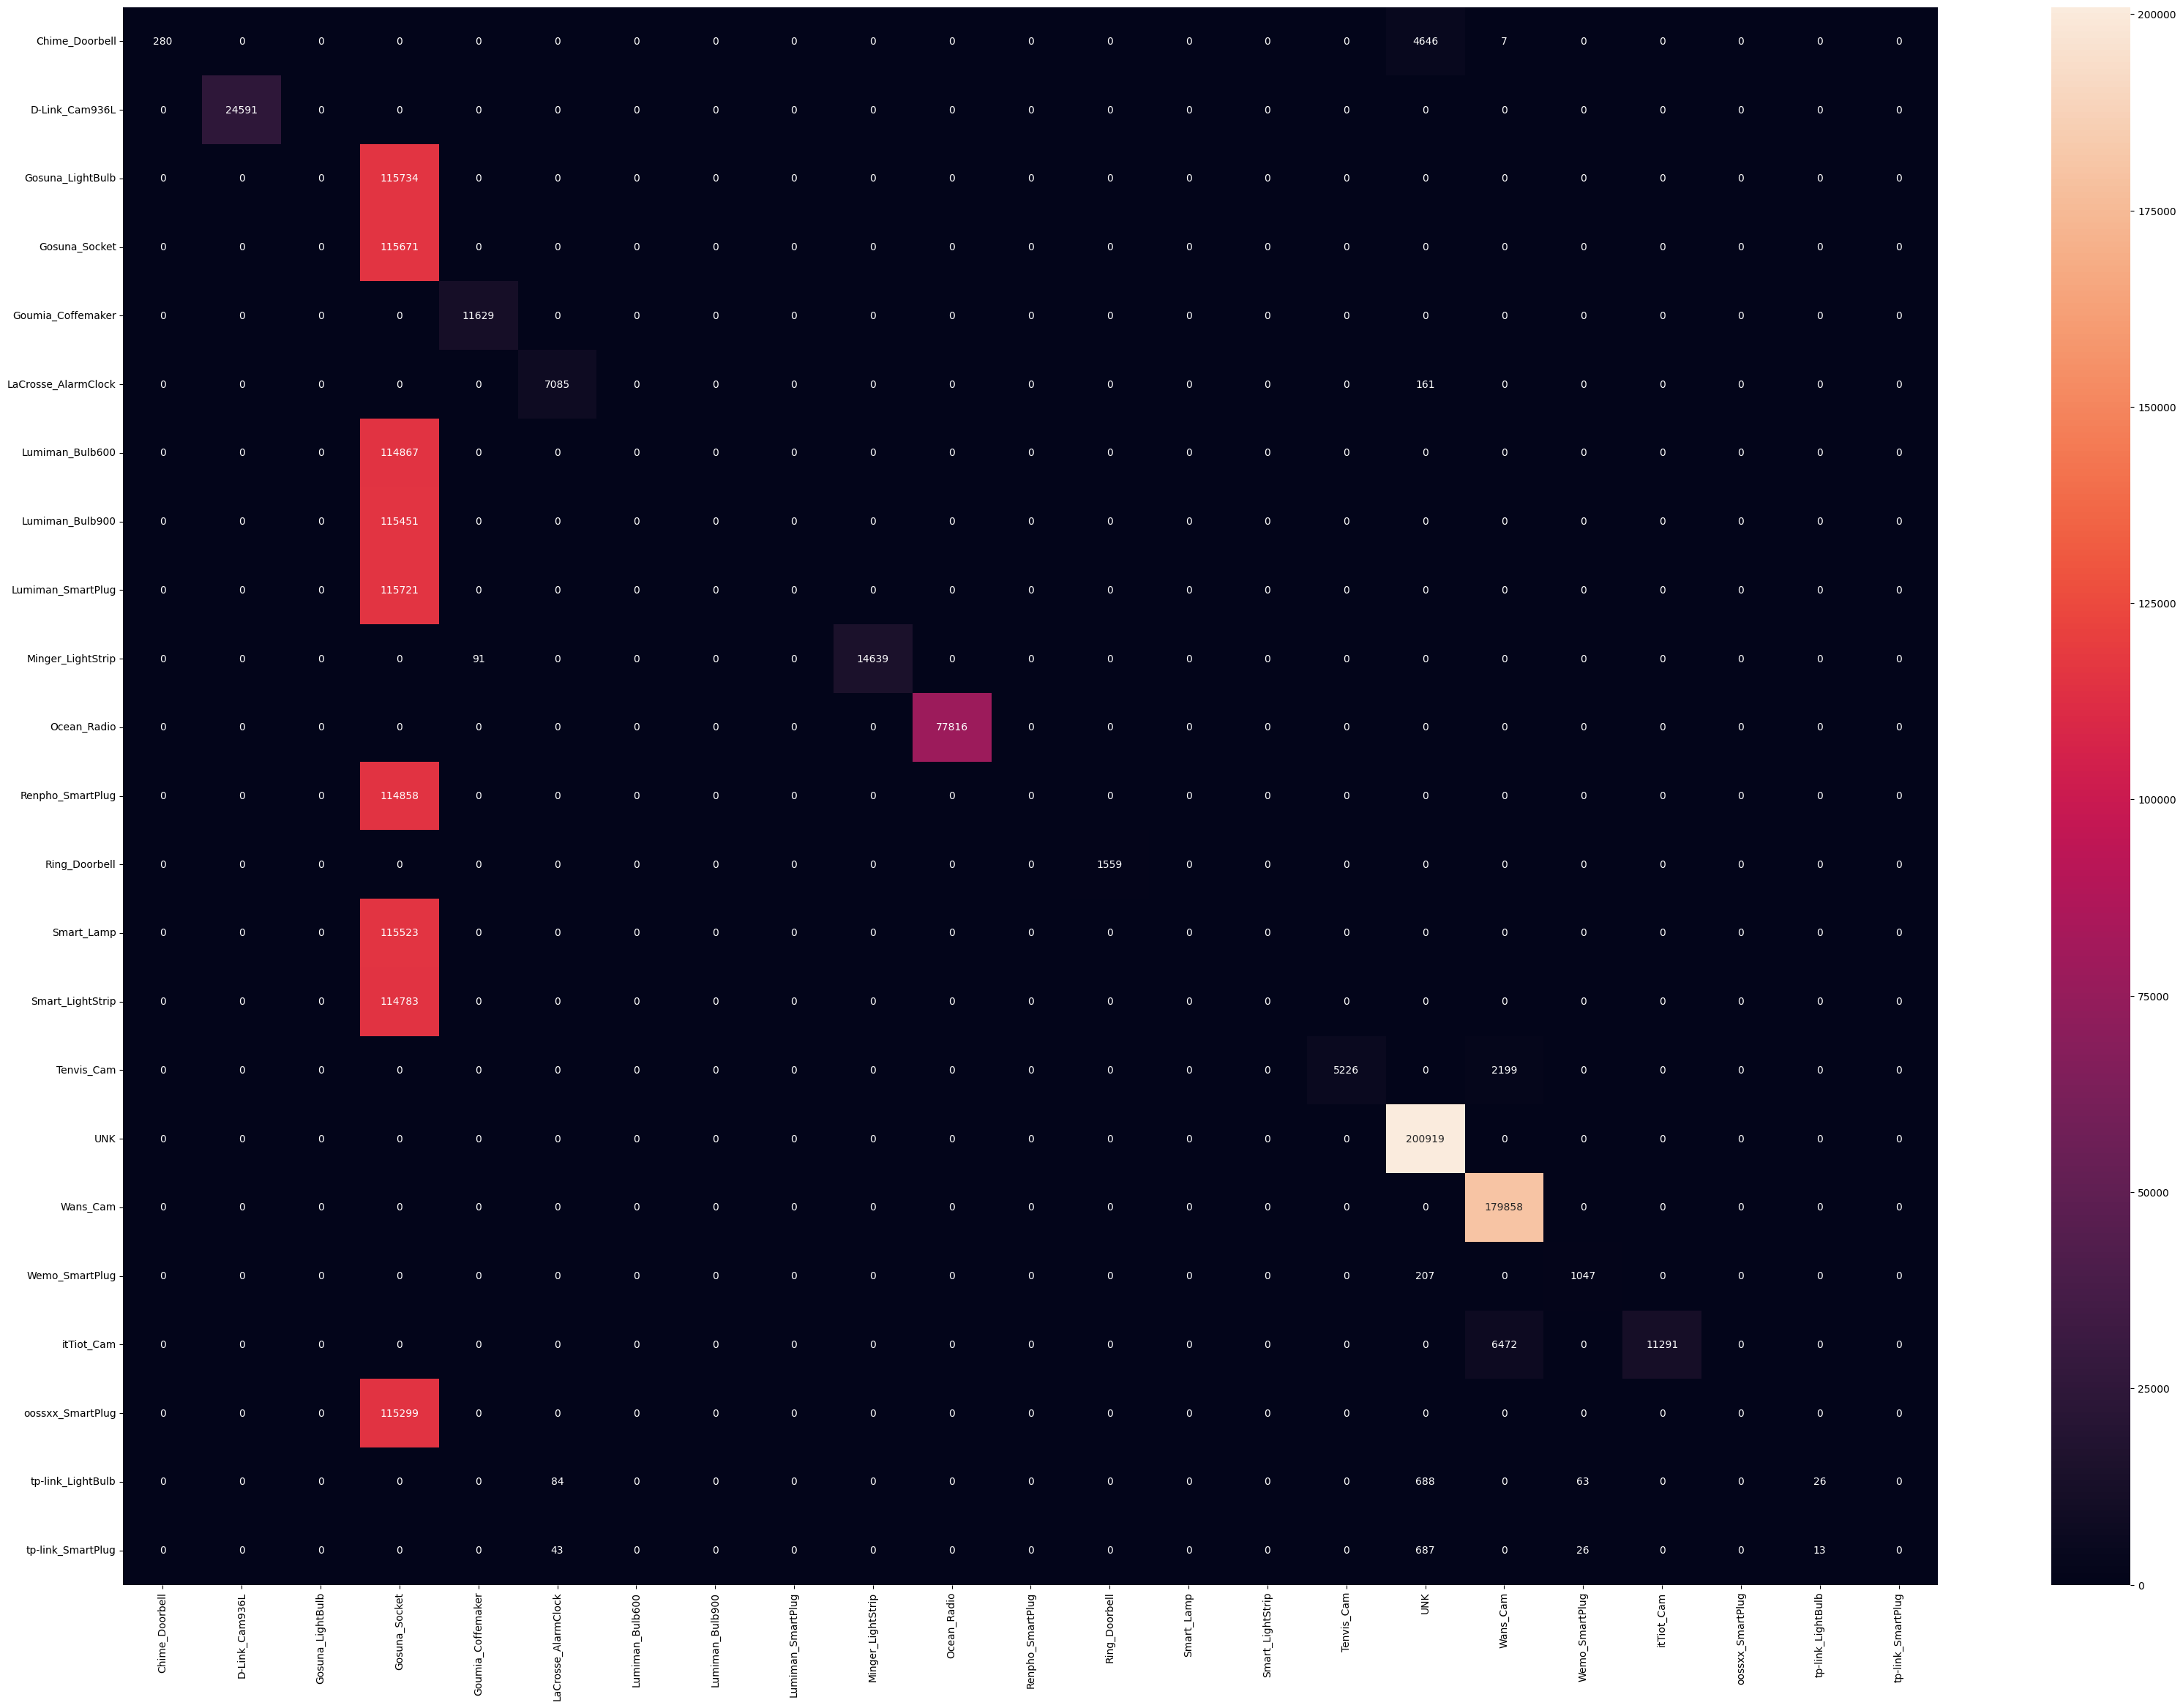

In [39]:
say=0
dataset="./results/13/"
folder(dataset)

dataset="./results/13/"
say+=1
train= 'Train.csv'
test='Test.csv'
mixed=True
step=13
sayac=1
output_csv=f"{dataset}/@{train[:-4]}@{test[:-4]}-{mixed}_IoTSentinel.csv"
dataset=f"Data"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step)) 